<a href="https://colab.research.google.com/github/yuleidner/DAV-6150/blob/main/M8_assn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#colab current default is sklearn .022 current it v1 updating
!pip install -U scikit-learn
# Installing yellow brick for their fun visualizers
!pip install -U yellowbrick
# updating mlextend 
!pip install -U mlxtend
# Installing sweetviz EDA visualizer
!pip install -U sweetviz

# Data Science: Module 8
## Practical Challenge: KNN and SVM
### Jacob Goodman & Alan Leidner
#### Nov 7, 2021
Assignment: https://yu.instructure.com/courses/50398/assignments/191959

# Introduction

This notebook follows up on the M7 assignment: https://github.com/yuleidner/DAV-6150/blob/main/M7/M7_assn.ipynb. The insurance company has asked us to revisit our work and develop an additional suite of classification models to see whether something other than a binary logistic regression model might be more effective for the designated task.

Our task for this assignment is to construct and compare/contrast a series of K-Nearest Neighbor and Support Vector Machine models that predict whether or not a given insurance company customer is likely to be to purchase an additional insurance product.

The data set we will be using is sourced from a Kaggle contribution:  https://www.kaggle.com/rluyck/insurance-company?select=Customer_data.csv

The data set is comprised of more than 14,000 observations of 1 response/dependent variable (which indicates whether or not the new insurance product was purchased) and 14 explanatory/independent variables. The insurance company gathered data about customers to whom they offered the new product. We are given information about whether they did or did not sign up for the new product, together with some customer information and information about their buying behavior of two other products. 

# Import Dependencies

In [ ]:
#import packages for data frames 
import numpy as np
import pandas as pd

#import pyplot and seaborn for graph creating
import matplotlib.pyplot as plt
import seaborn as sns 

#import for modeling & model evaluation
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from patsy import dmatrices
from yellowbrick.model_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import sweetviz as sv

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploratory Data Analysis <a id='1'></a>
The dataset was loaded into the DAV 6150 Github Repository here: https://raw.githubusercontent.com/yuleidner/DAV-6150/main/M7/M7_Data.csv. This notebook will now load the csv into a Pandas dataframe for analysis.

In [ ]:
# read a set of sample data from github. It contains information related to cars and insurance
filename = "https://raw.githubusercontent.com/yuleidner/DAV-6150/main/M7/M7_Data.csv"
df = pd.read_csv(filename)
pd.set_option('display.max_columns', None)# expands df to display all columns
df.head()

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


## Attribute Information
0. TARGET: Indicator of buying the new product (0 = no, 1= yes)
1. loyalty: Loyalty level, from low to high (0 to 3), 99 = unclassified
2. ID: Unique customer identifier
3. age: Age in years
4. city: Unique code per city
5. LOR: Length of relationship in years
6. prod_A: Bought Product A (0=no, 1=yes)
7. type_A: Type of product A
8. prod_B: Bought Product B (0=no, 1=yes)
9. type_B: Type of product B
10. turnover_A: Amount of money spent on Product A
11. turnover_B: Amount of money spent on Product B
12. contract: Type of contract
13. age_p: Age of partner in years
14. lor_m: Length of relationship in months


## Data Validation

In [ ]:
## a few methods will now be called to view summaries of this dataframe
df.shape

(14016, 15)

In [ ]:
#check to validate data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TARGET      14016 non-null  object 
 1   loyalty     14016 non-null  int64  
 2   ID          14016 non-null  int64  
 3   age         14016 non-null  int64  
 4   city        14016 non-null  int64  
 5   LOR         14016 non-null  int64  
 6   prod_A      14016 non-null  int64  
 7   type_A      14016 non-null  int64  
 8   type_B      14016 non-null  int64  
 9   prod_B      14016 non-null  int64  
 10  turnover_A  14016 non-null  float64
 11  turnover_B  14016 non-null  float64
 12  contract    14016 non-null  int64  
 13  age_P       14016 non-null  int64  
 14  lor_M       14016 non-null  int64  
dtypes: float64(2), int64(12), object(1)
memory usage: 1.6+ MB


We will need to transform our target from a Y/N object into a 1/0 int.

In [ ]:
df['TARGET'] = df['TARGET'].map({'Y':1 ,'N':0}).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TARGET      14016 non-null  int64  
 1   loyalty     14016 non-null  int64  
 2   ID          14016 non-null  int64  
 3   age         14016 non-null  int64  
 4   city        14016 non-null  int64  
 5   LOR         14016 non-null  int64  
 6   prod_A      14016 non-null  int64  
 7   type_A      14016 non-null  int64  
 8   type_B      14016 non-null  int64  
 9   prod_B      14016 non-null  int64  
 10  turnover_A  14016 non-null  float64
 11  turnover_B  14016 non-null  float64
 12  contract    14016 non-null  int64  
 13  age_P       14016 non-null  int64  
 14  lor_M       14016 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 1.6 MB


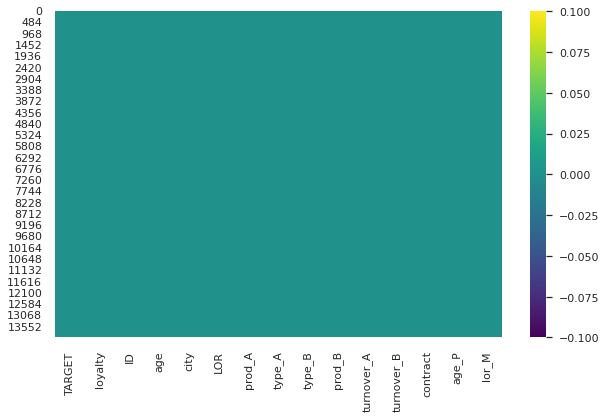

In [ ]:
#null visualization sanity check
sns.set(rc={'figure.figsize':(10,6)})
sns.heatmap(df.isnull(), cmap='viridis');

## Univariate Analysis

### Custom Function
We find ourselves turning to the same methods and visualizations for univariate analysis. The following function will be utilized to standardize our EDA and simplify code.

In [ ]:
def distbox (i,df , type = 'numeric',normalize=True):
  """ 
  This function is designed to provide distribution statics and visualizations of dataframe columns
  it takes in a column number and dataframe and can return:
   numerical output -
            1. the skewness of the column
            2. the kurtosis or spread
            3. the descriptive statistics from .describe()
            4. a histogram and boxplot
            
  OR categorical -        
            1. countplot
            2. values counts (either count or as percentages)
  """
  #best practice import dependencies in functions
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import warnings 
  warnings.filterwarnings("ignore", category=FutureWarning)
  c = df.iloc[:,i]
  plt.figure(figsize=(8,4))
  if type =='numeric':
    plt.subplot(1,2,1);#Histogram location
    sns.distplot(c);#calls a histogram
    plt.title(df.columns[i]);#adds title
    plt.subplot(1,2,2);#Boxplot location
    sns.boxplot(c);#calls a box and whisket plot
    plt.title(df.columns[i]);#adds title
    print("Skewness: %f" %c.skew()) #Adds Skew value
    # If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
    # If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
    # If the skewness is less than -1 or greater than 1, the data are highly skewed
    print("Kurtosis: %f" %c.kurt(skipna = True)) #Adds Kurtosis value (tail-ness)
    # While kurtosis determines the heaviness of the distribution tails.
    # Kurtosis > 3 thin and not spread
    # Kurtosis <3 moderate spread
    print(c.describe()) #Adds summary statistics of the variable


  elif type == 'categorical':
    sns.countplot(c)
    plt.title(df.columns[i]);#adds title
    print(c.value_counts(normalize=normalize))

  print("Nullcount: %f" %c.isnull().sum().sum())
  plt.show() # this will load image to console before executing next line of code

### TARGET

0    0.570776
1    0.429224
Name: TARGET, dtype: float64
Nullcount: 0.000000


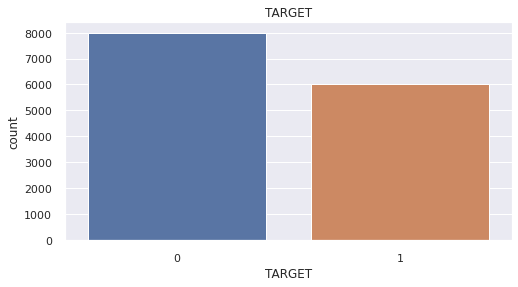

In [ ]:
distbox(0,df,type='categorical')

In [ ]:
count_0 = len(df[df['TARGET']==0])
count_1 = len(df[df['TARGET']==1])
pct_of_0 = count_0/(count_0+count_1)
print("percentage of no additional purchase is", pct_of_0*100)
pct_of_1 = count_1/(count_0+count_1)
print("percentage of subscription", pct_of_1*100)

percentage of no additional purchase is 57.077625570776256
percentage of subscription 42.922374429223744


These classes are relatively balanced.

### loyalty

99    0.498430
3     0.218964
1     0.176941
2     0.101670
0     0.003995
Name: loyalty, dtype: float64
Nullcount: 0.000000


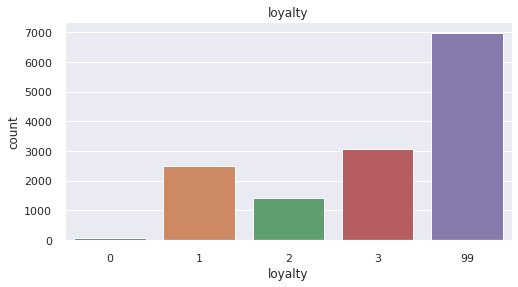

In [ ]:
distbox(1,df,type = 'categorical') 

**conclusions**

0 level loyalty is very sparse with only .39% of records and uncategorized 99 is over-represented. According to https://www.kaggle.com/rluyck/insurance-company?select=Customer_data.csv 99 represents unclassified data. 

We will transform this feature to preserve the ordinal nature. We will add 1 to every value, and then convert the uncategorized to 0. Although uncategorized is not lower than "0" we want to transform this feature while preserving ordinality.

### ID

Skewness: 1.214266
Kurtosis: 0.013023
count     14016.000000
mean      37672.440068
std       44855.639209
min           1.000000
25%        6741.500000
50%       13514.500000
75%       62738.000000
max      151811.000000
Name: ID, dtype: float64
Nullcount: 0.000000


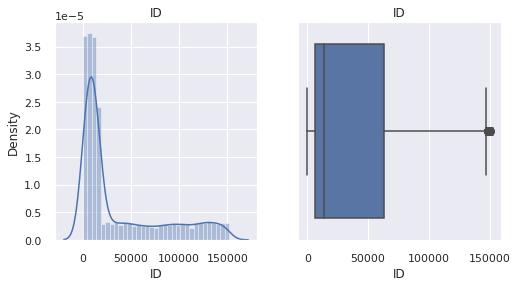

66853     2
147678    2
21091     2
107064    2
139877    2
         ..
5186      1
14042     1
11993     1
9944      1
16384     1
Name: ID, Length: 11008, dtype: int64
1.2732558139534884


In [ ]:
distbox(2,df )
print(df.iloc[:,2].value_counts())
print(df.iloc[:,2].value_counts().mean())

Some user IDs appear twice but most appear only 1 once. This column has an extreme level of cardinality. Perhaps useful features could be extracted from users occurring multiple times or they could represent duplicates that need to be dropped.
 

In [ ]:
#examining one of the extra columns 
df[df['ID']==147678]

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
2919,1,99,147678,28,2,1,1,3,3,1,448.420392,218.86623,2,28,15
13927,1,99,147678,28,2,1,1,3,3,1,448.420392,218.86623,2,28,15


**conclusions** 
This looks like a duplicate record that we will remove. This column is an index and should not be included in models, or other duplicate entries.

### age   
the age customer.


Skewness: 1.171141
Kurtosis: 1.368278
count    14016.000000
mean        35.882920
std         12.974634
min          5.000000
25%         25.000000
50%         33.000000
75%         43.000000
max        102.000000
Name: age, dtype: float64
Nullcount: 0.000000


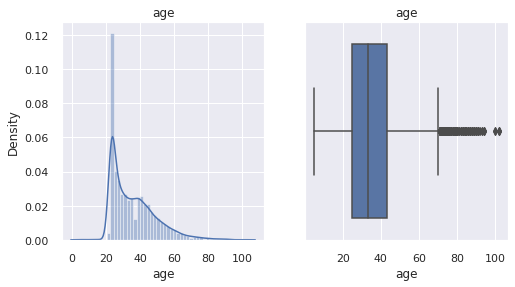

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
2976,1,99,150547,102,2,1,0,0,0,0,436.054680,258.432573,2,102,15
3253,0,99,513,100,2,0,0,0,0,0,347.703304,209.913216,2,100,3
5454,0,3,5094,102,2,1,0,0,3,1,367.491079,3210.235891,2,102,15
7910,0,99,10232,100,2,0,0,0,0,0,379.502621,235.877083,2,100,3
13984,1,99,150547,102,2,1,0,0,0,0,436.054680,258.432573,2,102,15


In [ ]:
distbox(3,df)
display(df[df['age']>95])

**conclusions**   
Age in this data set is right-skewed. While there are a few large values none that are outside the realm of possibility. We will standardize and normalize.

### city  
id for each city 

2      0.978881
1      0.001998
0      0.001855
8      0.001498
9      0.001427
         ...   
127    0.000071
131    0.000071
115    0.000071
107    0.000071
187    0.000071
Name: city, Length: 65, dtype: float64
Nullcount: 0.000000


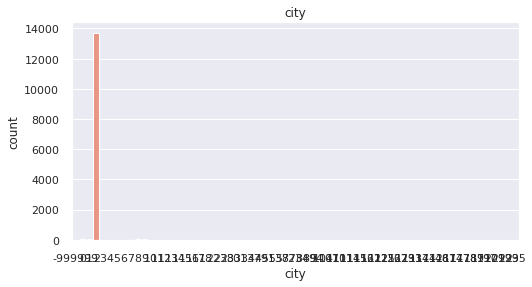

In [ ]:
distbox(4,df,type= 'categorical') 

In [ ]:
df.city[df.iloc[:,4]<0].unique()

array([-999999])

In [ ]:
df.city[df.iloc[:,4]<0].count()

10

**conclusions** 

97% of the city values are in a single class out of 65 distinct values. We think the negative value is probably a null stand-in.
   
To handle this feature we will convert it to an indicator column "not in city_2" effectively turning this into an indicator column.

### LOR   
Length of relationship in years

Skewness: 1.108936
Kurtosis: 1.175228
count    14016.000000
mean         0.926299
std          0.965212
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: LOR, dtype: float64
Nullcount: 0.000000


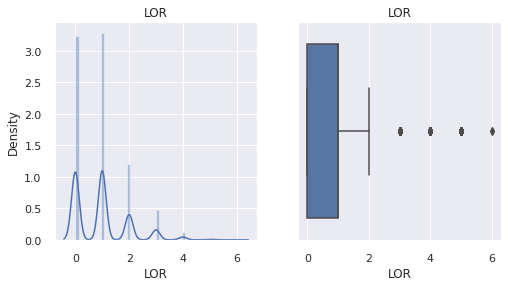

In [ ]:
distbox(5,df)

**conclusion** 

The length of relationship column is right-skewed with a few outliers but no signs of unrealistic values. We will standardize and normalize.

### prod_A
customer bought product A.  
1 = yes 0 = no

1    7482
0    6534
Name: prod_A, dtype: int64
Nullcount: 0.000000


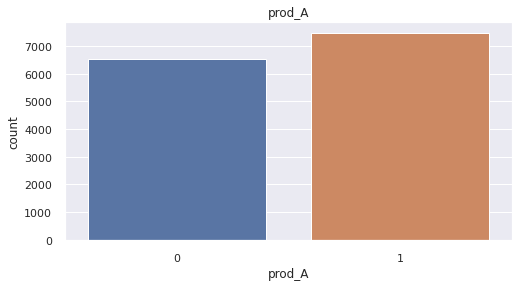

In [ ]:
distbox(6,df,type='categorical',normalize=False)

**conclusion** 

The classes are fairly evenly distributed. They seem to have the opposite proportion to our response variable. No data preparation work should be needed. 

### type_A
The type of product A is

3    7452
0    6534
6      30
Name: type_A, dtype: int64
Nullcount: 0.000000


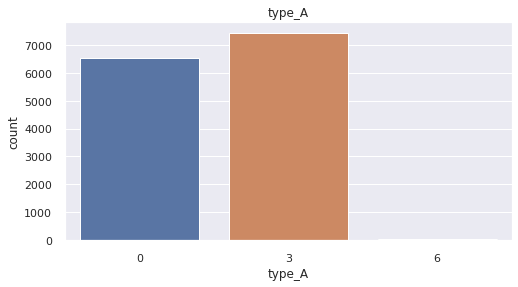

In [ ]:
distbox(7,df,type='categorical',normalize=False)

In [ ]:
# checking to see type_A is always = 0 when Prod_a is 
sum(df.iloc[:,7]==df.iloc[:,6])

6534

**Conclusion** 

The type_A feature has a very sparse class and 0 values are = to zero values in prod_A. 

If dummied only 1 0 column should be retained. 
The sparse class might be left due to a limited number of classes and included in the stratification term of test train split.


### type_B
type of product B

3    0.561787
0    0.400542
6    0.035174
9    0.002497
Name: type_B, dtype: float64
Nullcount: 0.000000


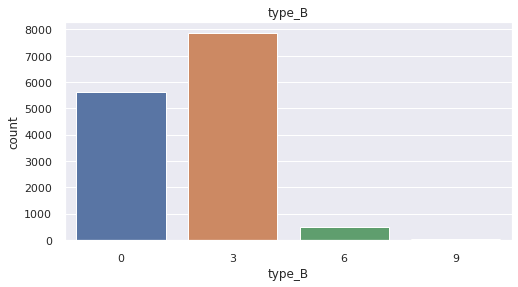

In [ ]:
distbox(8,df,type='categorical')

**conclusion** 

The type_B feature has two sparse classes. The sparse classes might be left due to the limited number of classes and included in the  stratification term of test train split.

### prod_B

1    8402
0    5614
Name: prod_B, dtype: int64
Nullcount: 0.000000


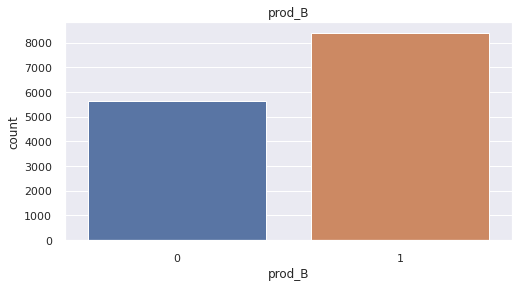

In [ ]:
distbox(9,df,type='categorical',normalize=False)

In [ ]:
# validate zero condition is present here as well between prod_b and type_B
sum(df.iloc[:,8]==df.iloc[:,9])

5614

**conclusion**

The prod_B feature is relatively evenly distributed, but 0 values are equal to the zero values in type_B. If dummied only 1 0 column should be retained. 

### turnover_A  
 Amount of money spent on Product A

Skewness: 21.220275
Kurtosis: 900.222515
count    14016.000000
mean       379.161320
std         92.612207
min        300.095909
25%        334.919412
50%        367.891493
75%        399.744923
max       5568.784139
Name: turnover_A, dtype: float64
Nullcount: 0.000000


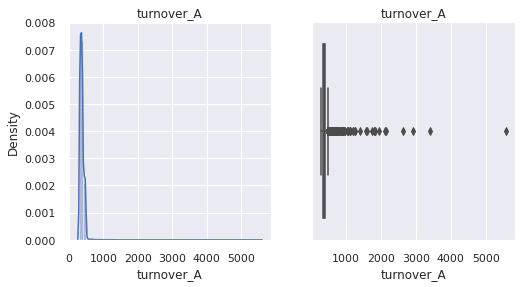

In [ ]:
distbox(10,df)

In [ ]:
# exploring outliers
df[df.iloc[:,10]>2000]

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
4998,0,99,4129,43,2,1,1,3,3,1,2630.436929,2513.647649,2,43,15
6116,0,3,6523,51,2,1,1,3,3,1,3417.423272,3245.107895,2,51,15
7857,0,1,10110,57,2,2,1,3,3,1,5568.784139,5442.041434,2,57,27
8154,0,2,10768,45,2,1,1,3,3,1,2106.224034,2030.227497,2,45,15
8710,0,2,11919,49,2,1,1,3,3,1,2149.771342,2020.890297,2,49,15
9026,0,99,12616,71,2,1,1,3,3,1,2921.246639,2770.526018,2,71,15


**conclusion**

Outliers severely skew this feature but may contain variance. We will normalize and standardize.

### turnover_B
 Amount of money spent on Product B

Skewness: 8.132714
Kurtosis: 93.168773
count    14016.000000
mean       328.628207
std        475.616525
min        191.962852
25%        219.406925
50%        237.656757
75%        264.131538
max      12249.084770
Name: turnover_B, dtype: float64
Nullcount: 0.000000


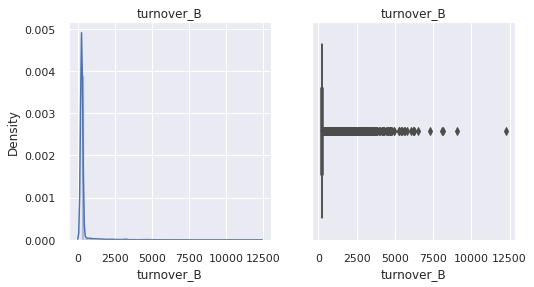

In [ ]:
distbox(11,df)

**Conclusion**

Outliers severely skew this  feature but may contain variance. We will normalize and standardize.

### contract
type of contract

2    1.0
Name: contract, dtype: float64
Nullcount: 0.000000


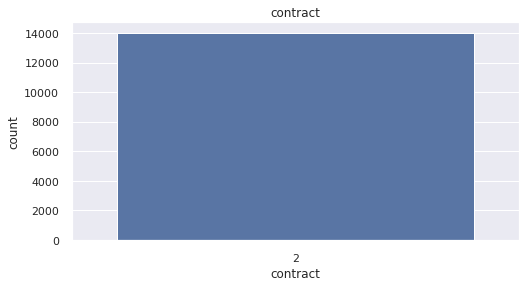

In [ ]:
distbox(12,df,type = 'categorical')

**conclusion** 

This column has no variance and will be dropped.

### age_P
Age of partner in years

Skewness: 1.171141
Kurtosis: 1.368278
count    14016.000000
mean        35.882920
std         12.974634
min          5.000000
25%         25.000000
50%         33.000000
75%         43.000000
max        102.000000
Name: age_P, dtype: float64
Nullcount: 0.000000


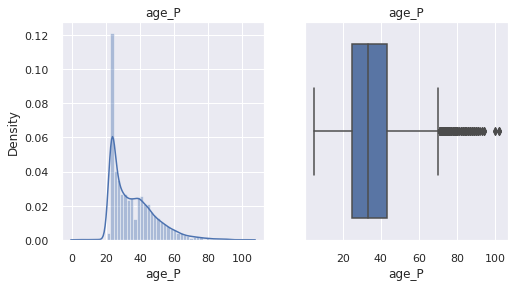

In [ ]:
distbox(13,df)

This column appears to have a very similar distribution as age, right-skewed without unreasonable outliers. We will check for independence in the next section.

In [ ]:
#sanity check
df[['age','age_P']].head()

,age,age_P
0,66,66
1,45,45
2,42,42
3,31,31
4,62,62


In [ ]:
df[['age','age_P']].corr()

,age,age_P
age,1.0,1.0
age_P,1.0,1.0


**conclusion** 

age_P is a duplicate column and will be dropped.

### lor_M
Length of relationship in months

Skewness: 1.108936
Kurtosis: 1.175228
count    14016.000000
mean        14.115582
std         11.582550
min          3.000000
25%          3.000000
50%         15.000000
75%         15.000000
max         75.000000
Name: lor_M, dtype: float64
Nullcount: 0.000000


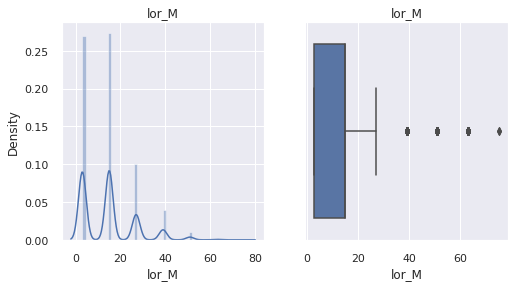

In [ ]:
distbox(14,df)

**conclusion** 

This column has the same distribution as LOR, right-skewed without unreasonable outliers. It is dependant which we will verify in the multivariate analysis section. We will likely drop LOR as it contains the same information but on a scale of 12 months, where lor_M is on a 3-month scale, allowing for added granularity.

actions:
* drop either lor_M or LOR
* standardize and normalize if we retain the feature

## Multivariate Analysis

### Quantitative Independence

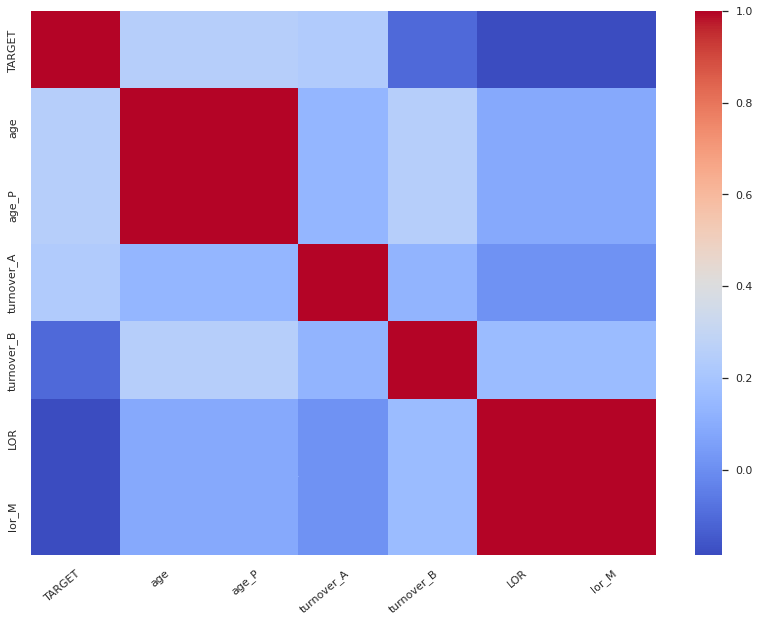

In [ ]:
#Correlation analysis for columns which are not categorical
plt.figure(figsize=(14,10))
sns.heatmap(df[['TARGET','age','age_P','turnover_A','turnover_B','LOR','lor_M']].corr(),cmap='coolwarm',annot=False);
plt.xticks(rotation=40 , rotation_mode='anchor',ha="right");

This reconfirms our decision to drop age_P and LOR

In [ ]:
df.groupby('TARGET').mean()

,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
TARGET,,,,,,,,,,,,,,
0,39.791625,8366.446750,33.027125,-747.257125,1.081375,0.673000,2.025000,2.411625,0.74475,360.368141,371.263176,2.0,33.027125,15.976500
1,64.464428,76643.175864,39.680519,-662.669548,0.720080,0.348737,1.053191,1.263630,0.40625,404.152250,271.932769,2.0,39.680519,11.640957


loyalty, age, prod_A, type_A, type_B, turnover_A, and turnover_B seem like they will contain a good amount of variance to predict our response variable.

### Categorical Independence

Checking for the independence of categorical/ordinal data.

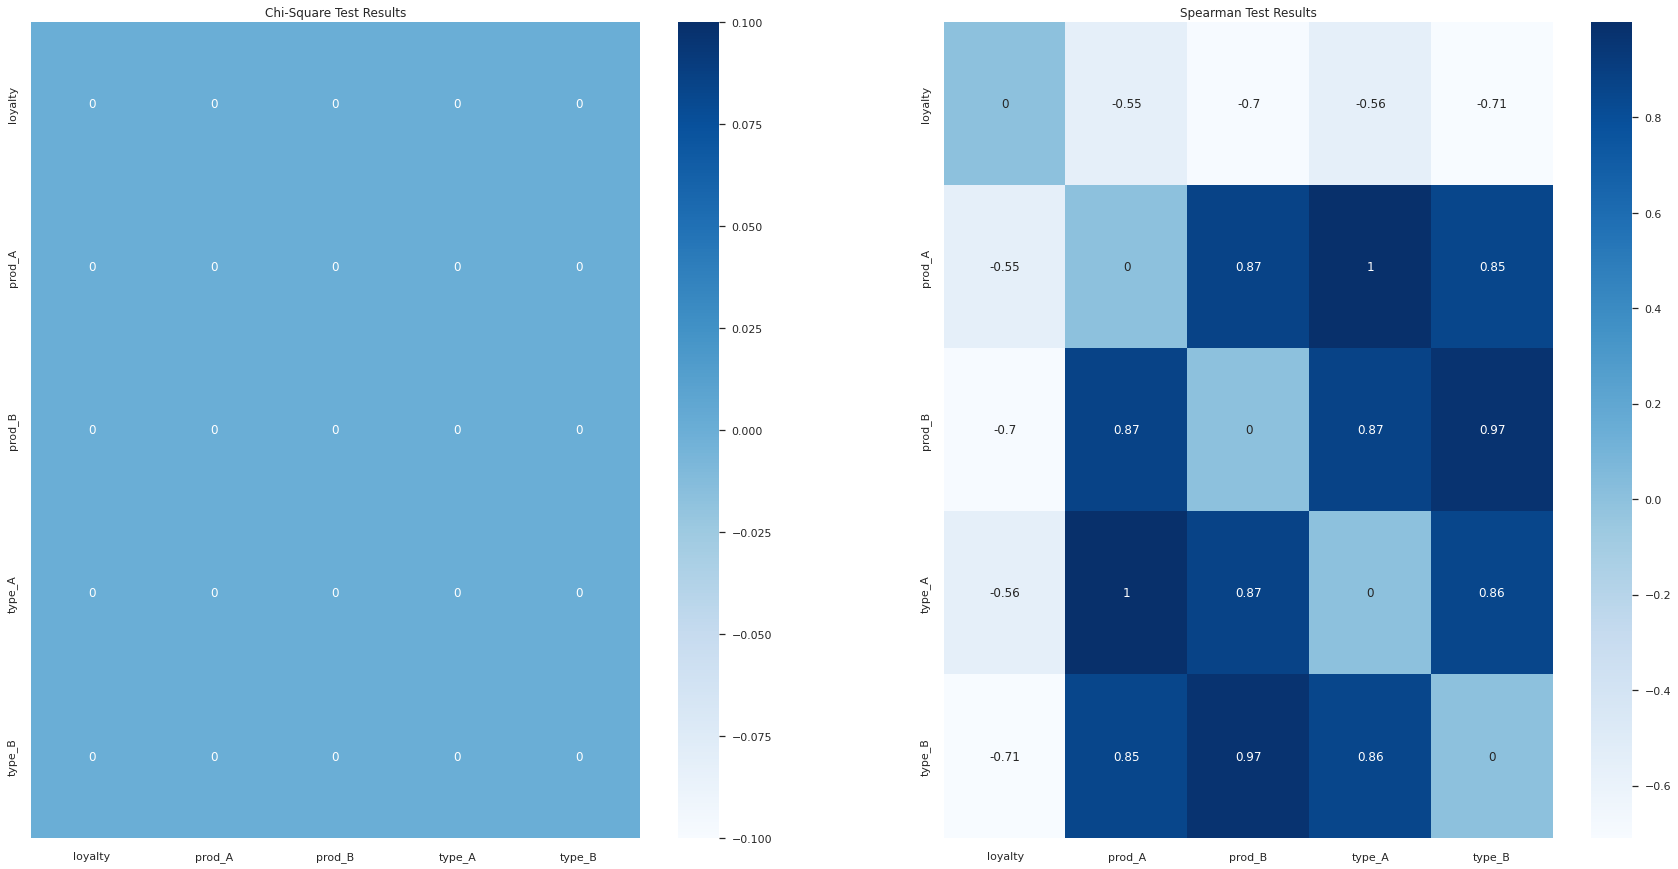

In [ ]:
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
cat_columns = ['loyalty', 'prod_A','prod_B', 'type_A', 'type_B']#not including city at this stage because the functions do not like negative numbers

chi_ps =[]
spearman = []
for cat in cat_columns:
  intermediate_P = []
  intermediat_spear = []
  for second_cat in cat_columns:
    if cat == second_cat:
      intermediate_P.append(0)
      intermediat_spear.append(0)
      continue
    chi = chi2(df[cat].values.reshape(-1, 1),df[second_cat].values.reshape(-1, 1))
    intermediate_P.append(chi[1][0])
    spear = spearmanr(df[cat].values.reshape(-1, 1),df[second_cat].values.reshape(-1, 1))
    intermediat_spear.append(spear[0])
  chi_ps.append(intermediate_P)
  spearman.append(intermediat_spear)


df_pvalues = pd.DataFrame(data= chi_ps,index=cat_columns,columns=cat_columns)
df_spearman = pd.DataFrame(data= spearman,index=cat_columns,columns=cat_columns)
#print(intermediat_spear)
#df_pvalues
fig = plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
sns.heatmap(df_pvalues, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.subplot(1,2,2)
sns.heatmap(df_spearman, annot=True, cmap='Blues')
plt.title('Spearman Test Results')
plt.show()

**conclusion**  
$\tilde{\chi}^2$ - our columns pairs  have a P-value of less than .05 from the test. We primarily accept the alternative hypothesis of the $\tilde{\chi}^2$ that these columns are not independent. 

Spearman r - confirms they are not independent, which is not ideal for logistic regressions.

## TARGET Compared to Features

In [ ]:
my_report = sv.analyze(df, target_feat =  'TARGET')

                                             |          | [  0%]   00:00 -> (? left)


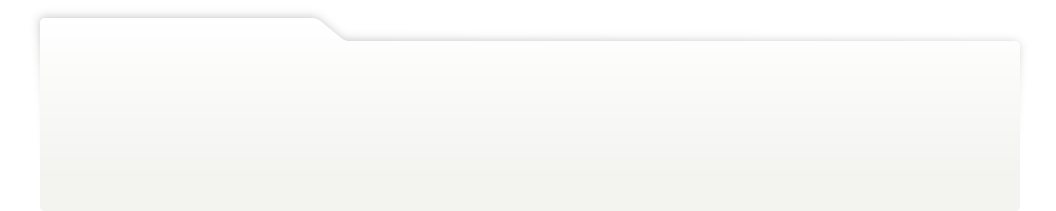
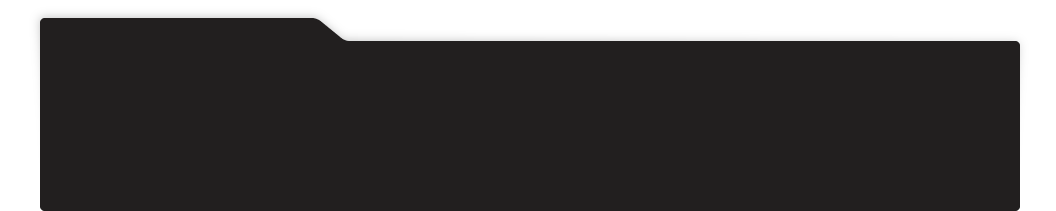
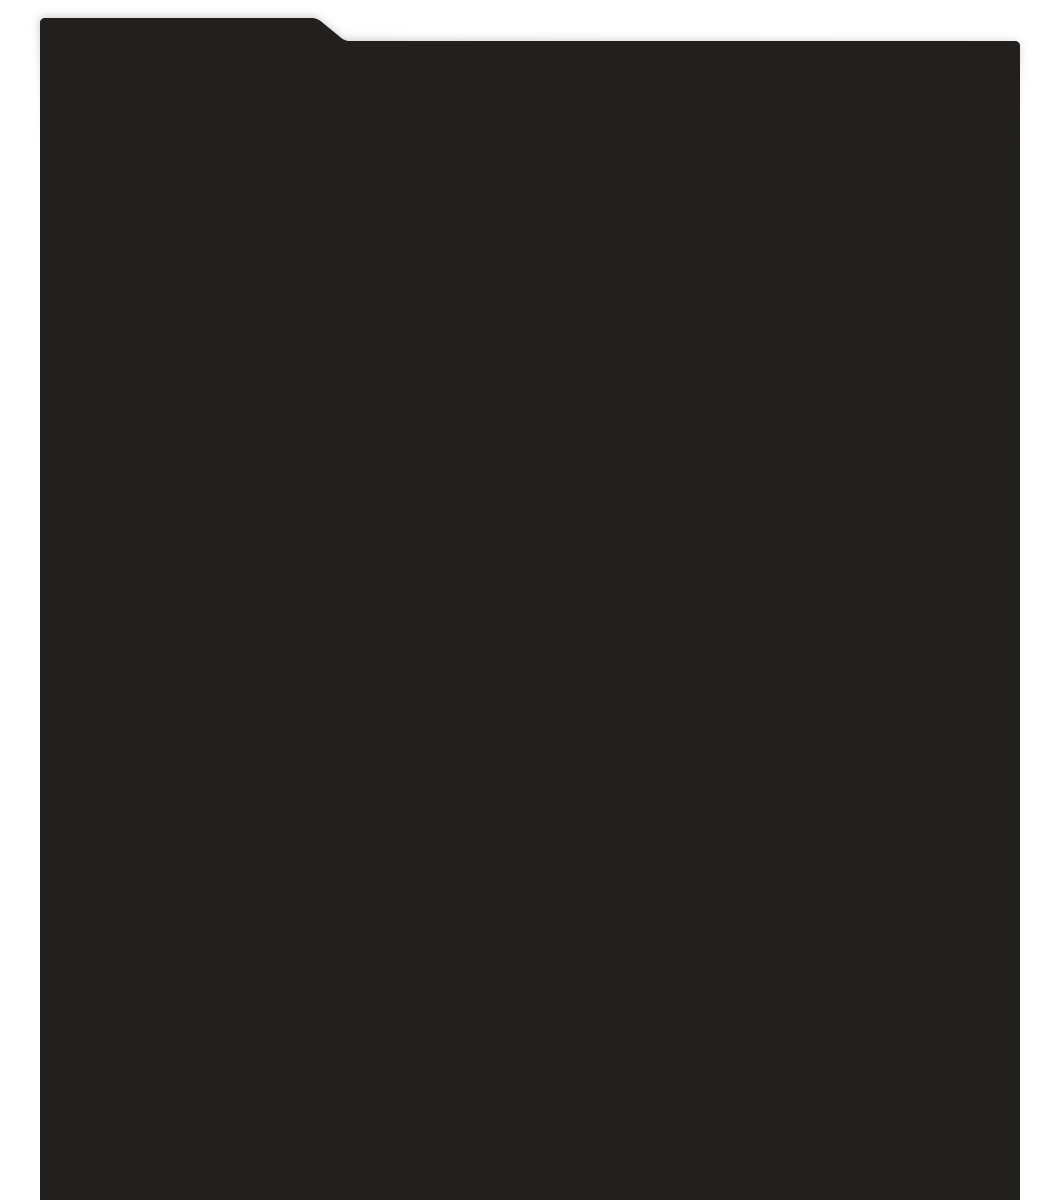
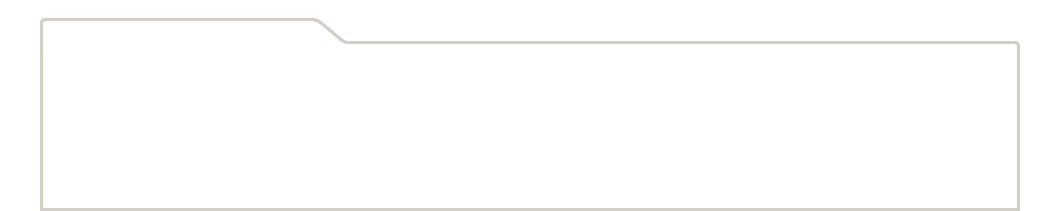
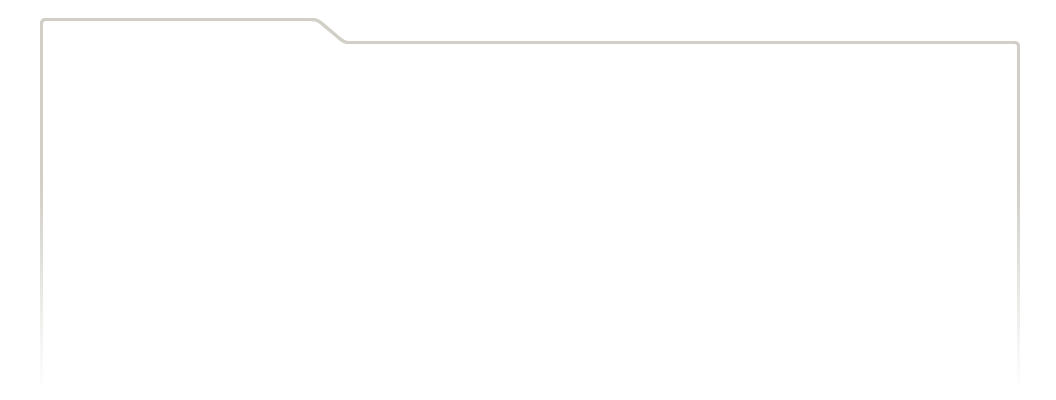
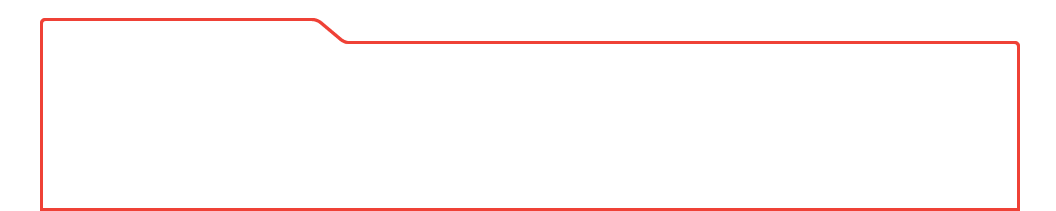
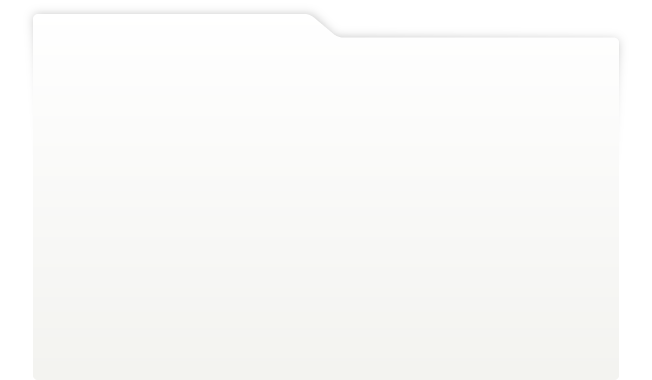
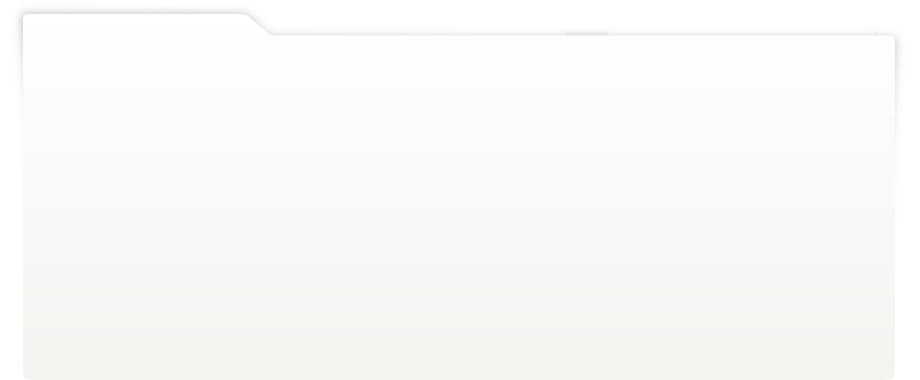
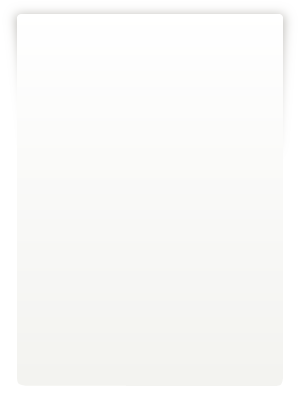
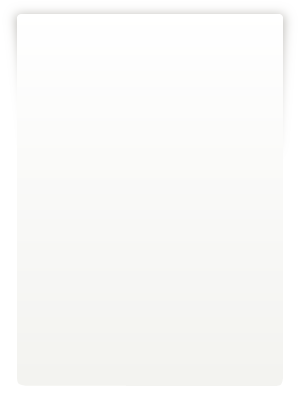
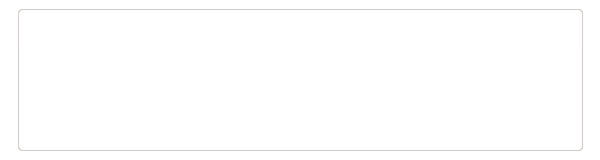
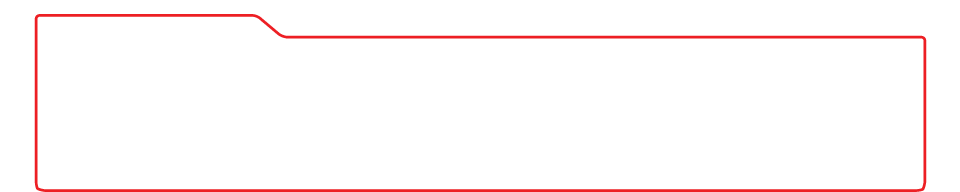
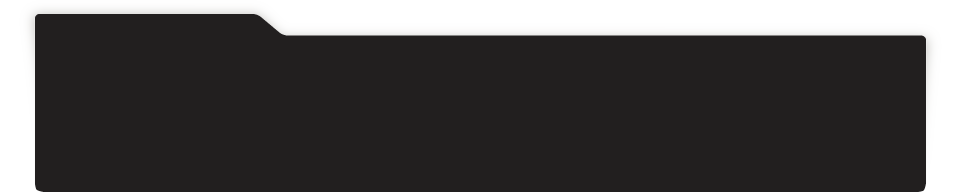
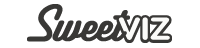
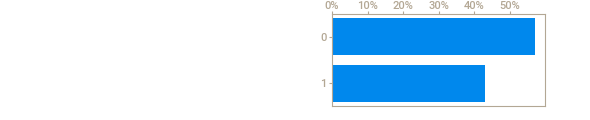
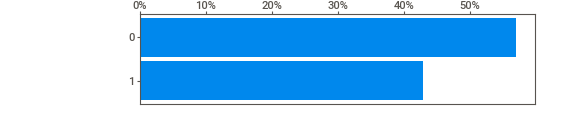
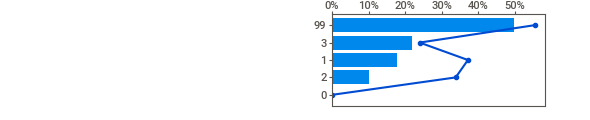
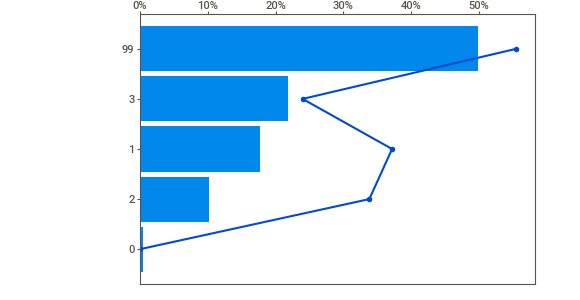
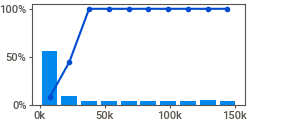
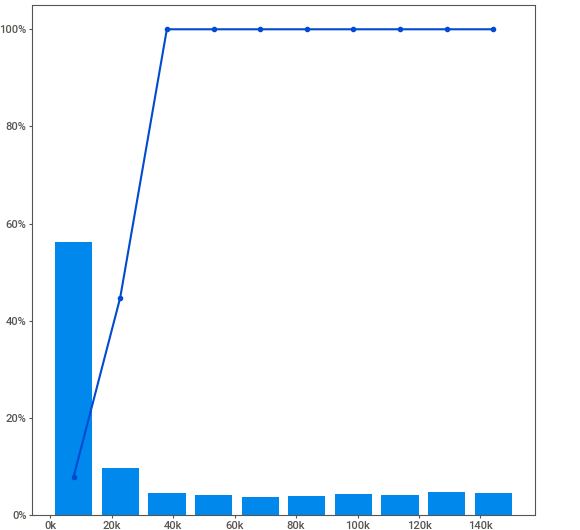
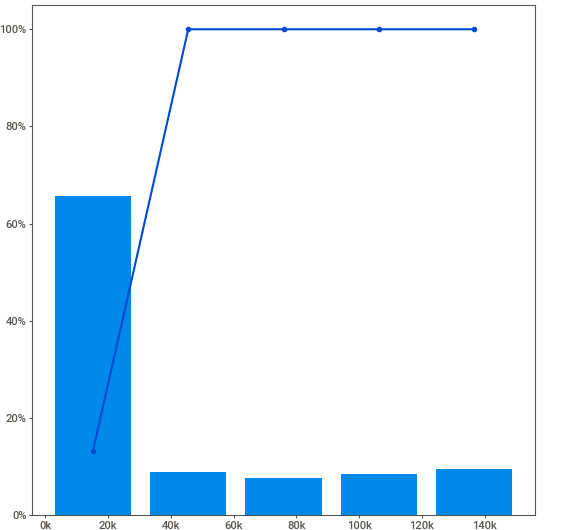
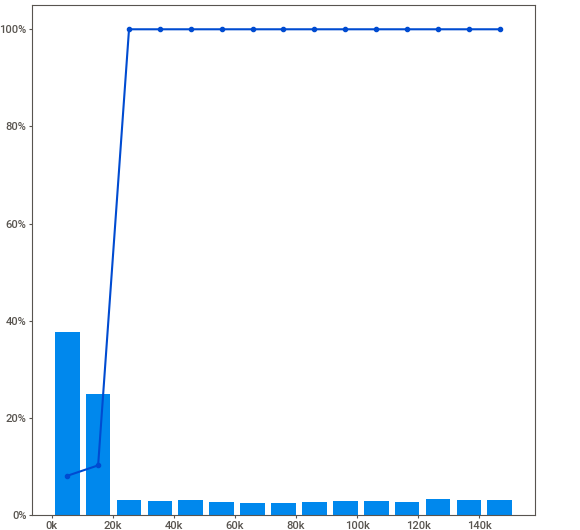
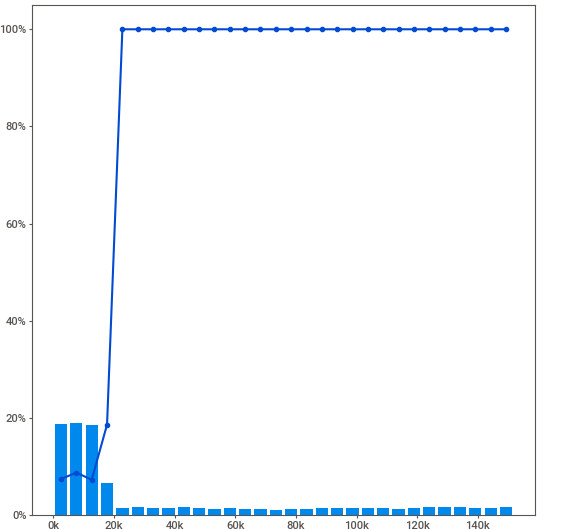
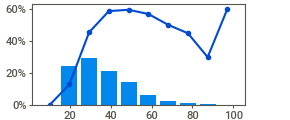
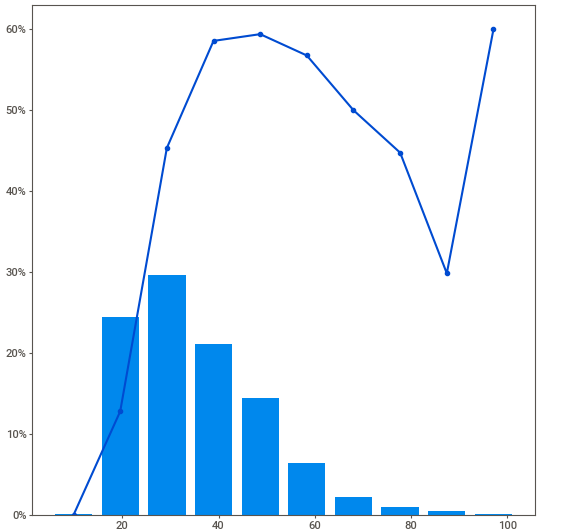
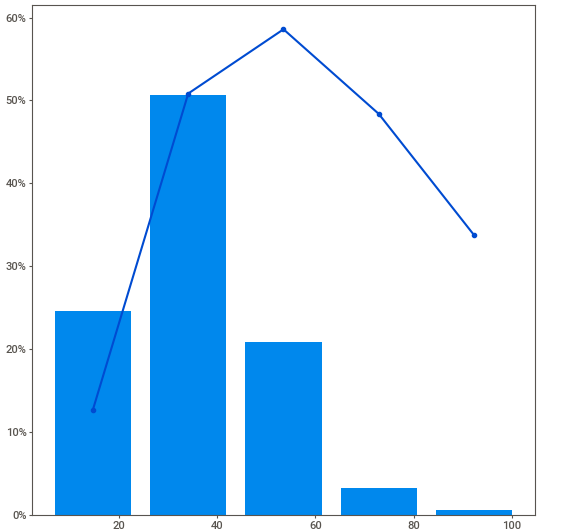
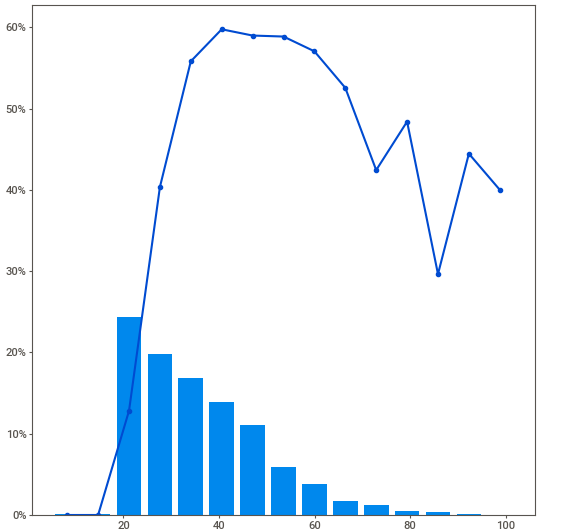
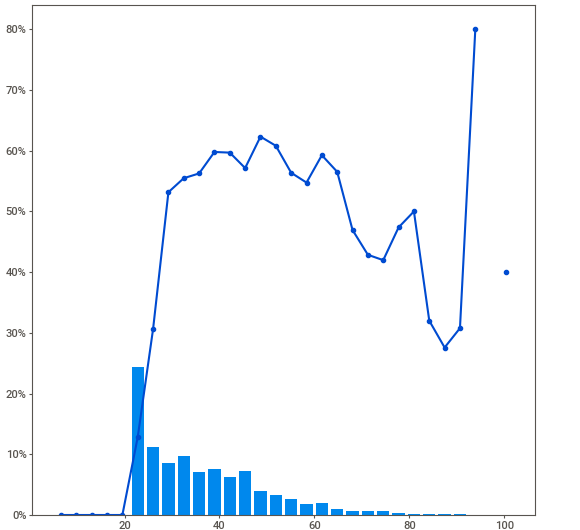
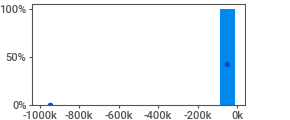
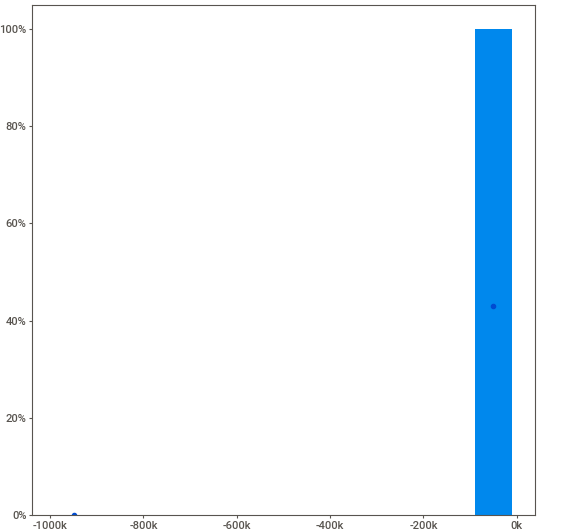
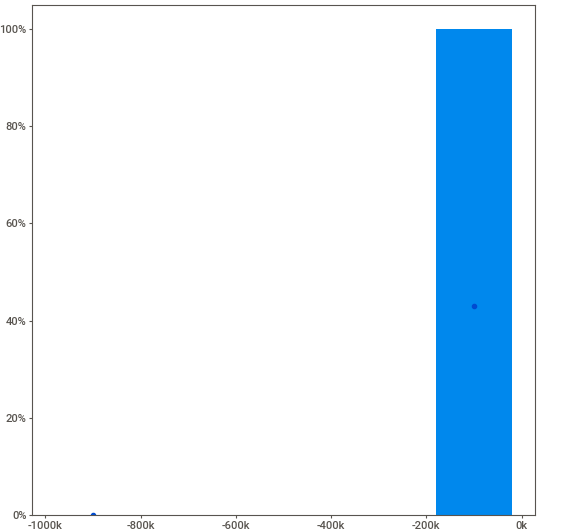
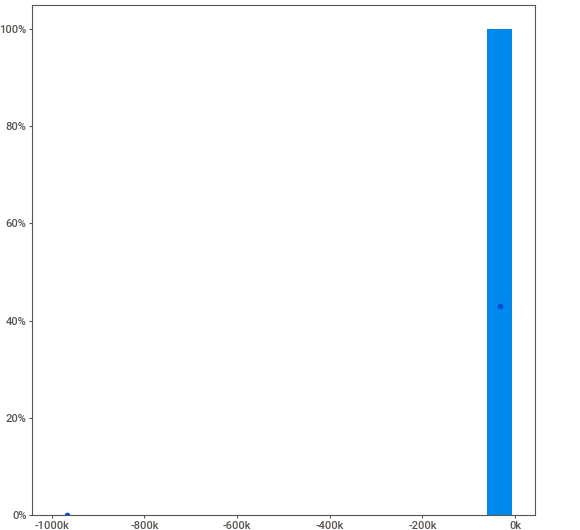
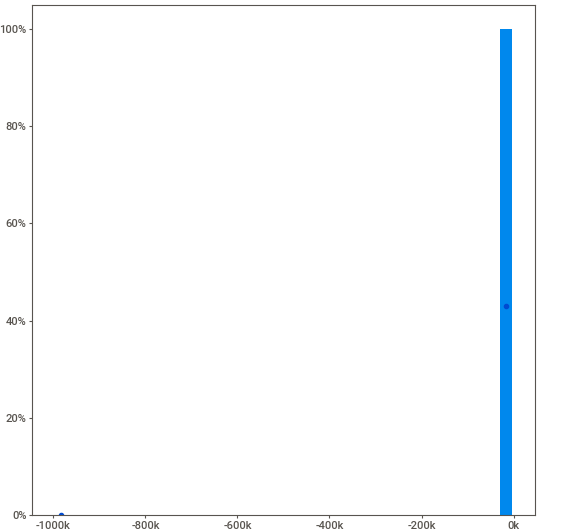
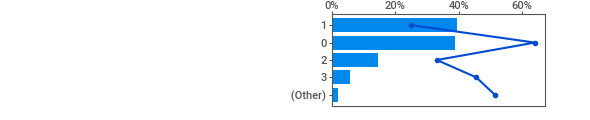
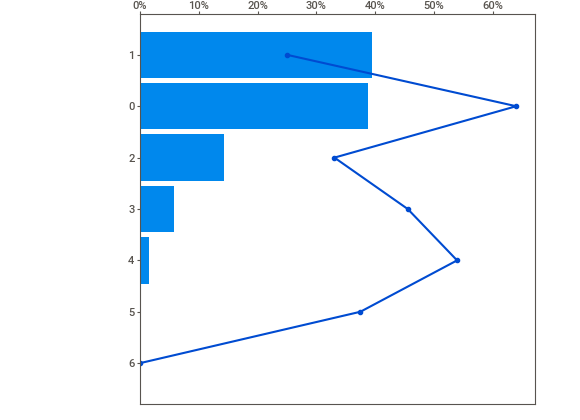
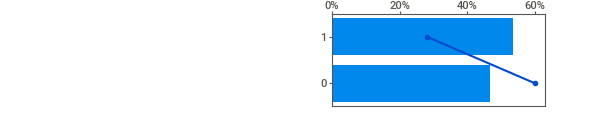
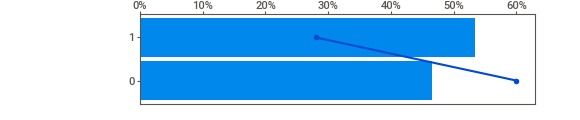
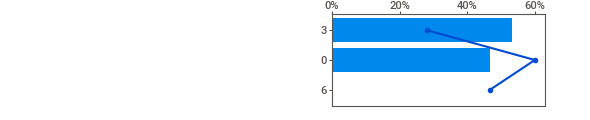
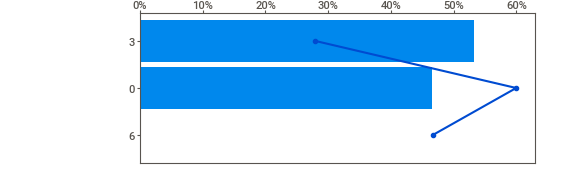
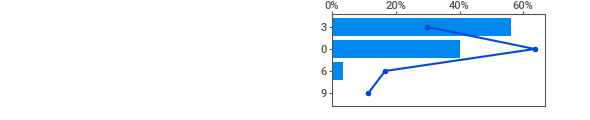
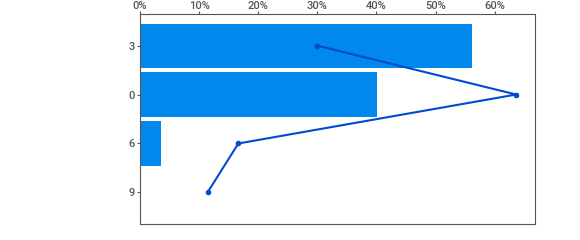
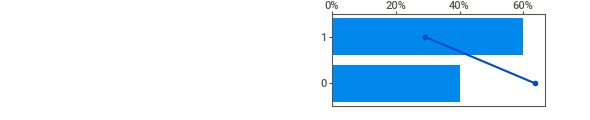
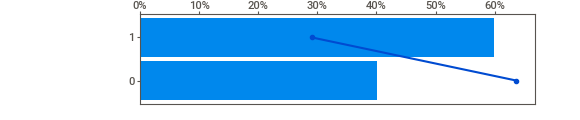
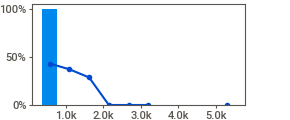
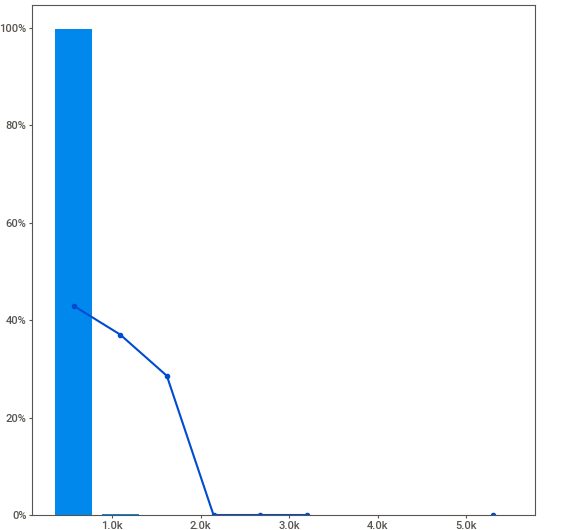
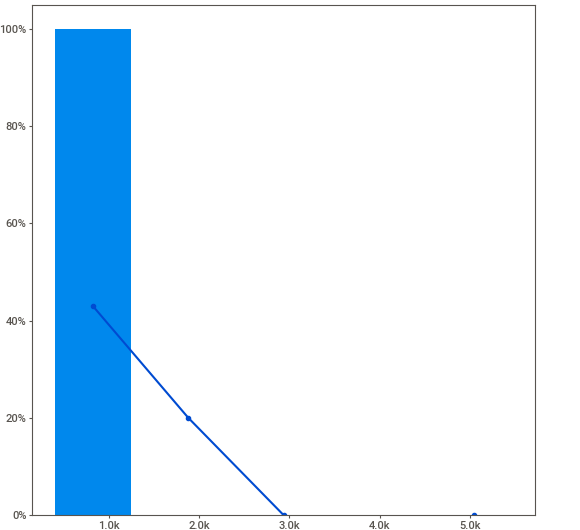
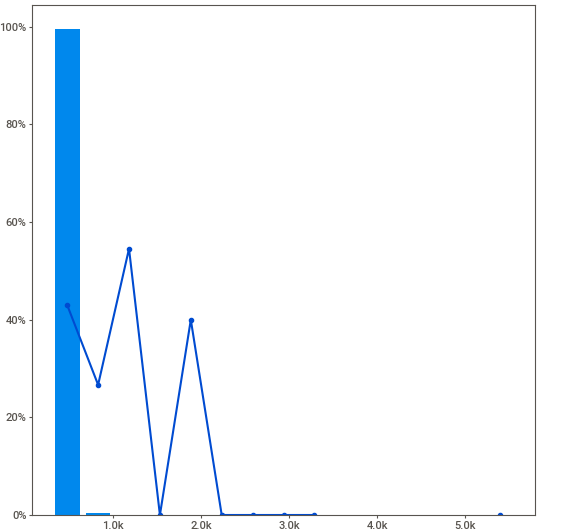
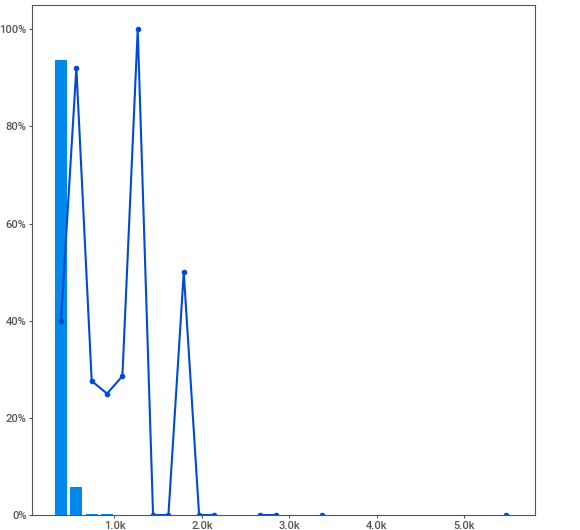
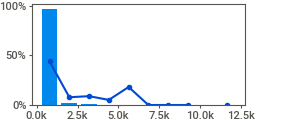
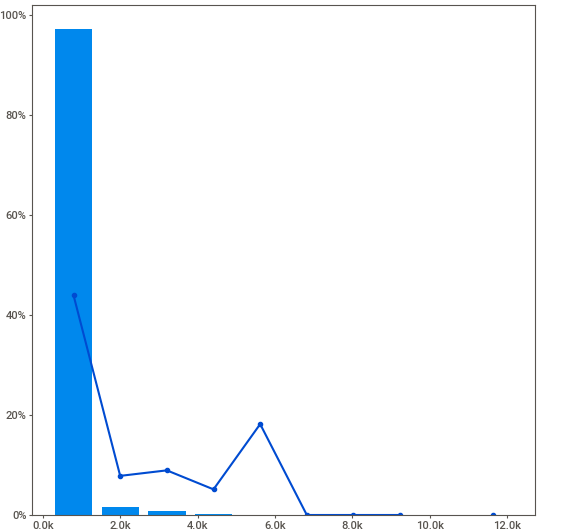
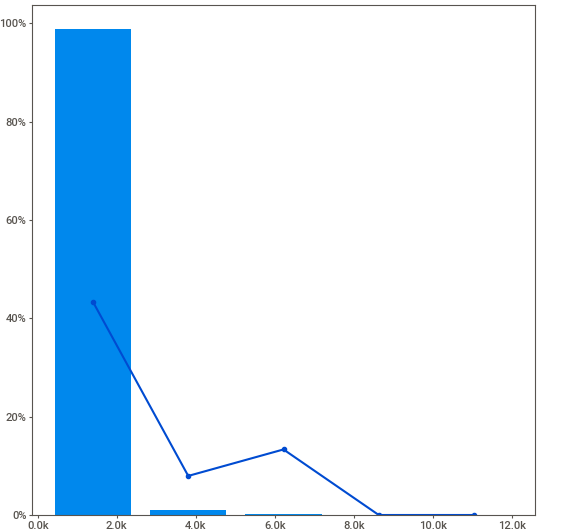
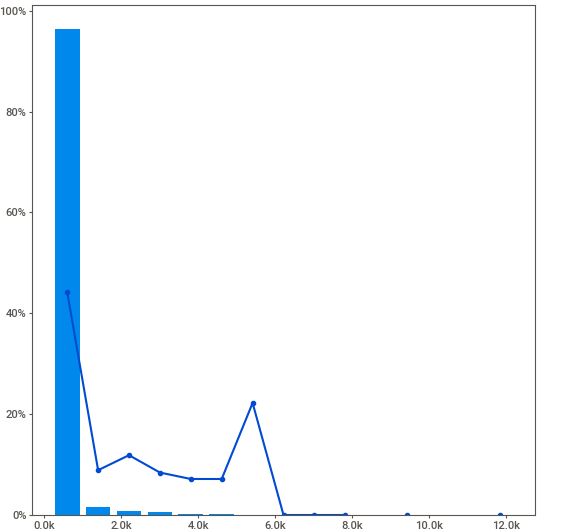
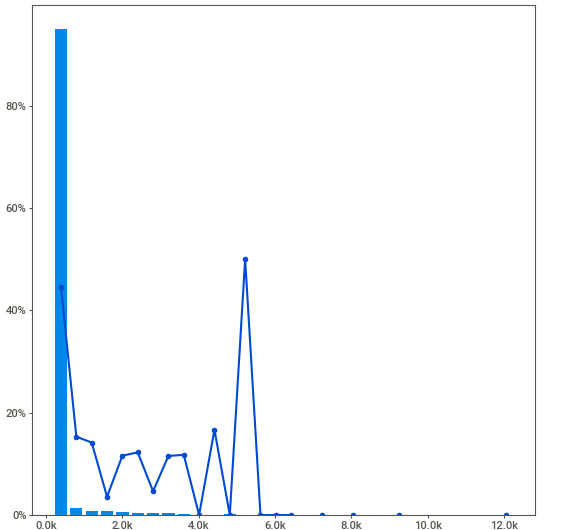
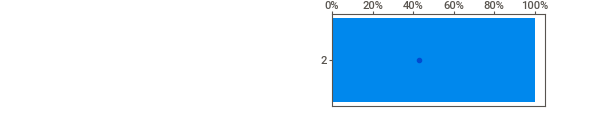
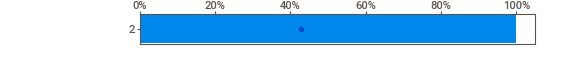
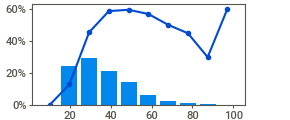
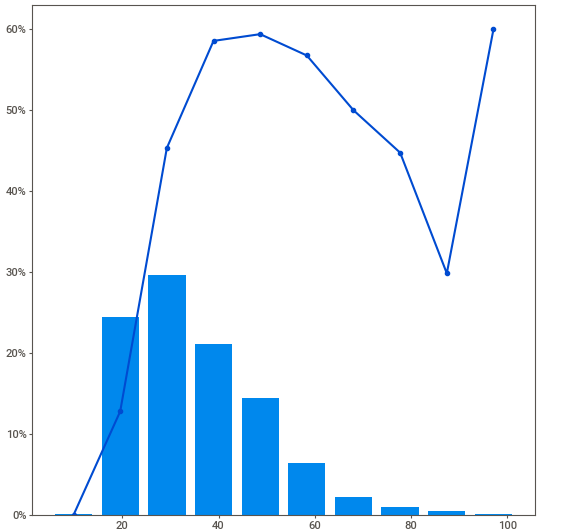
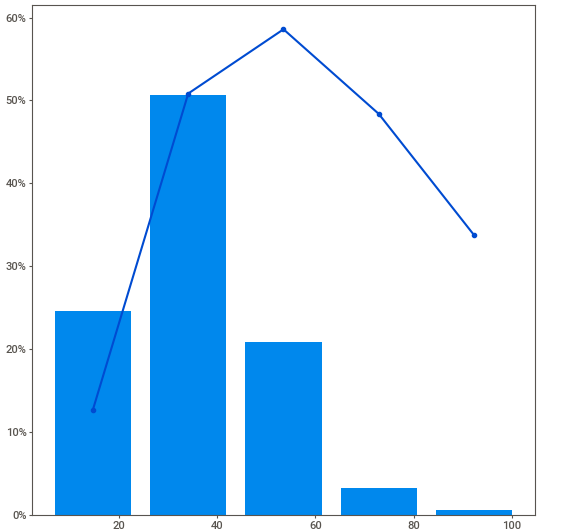
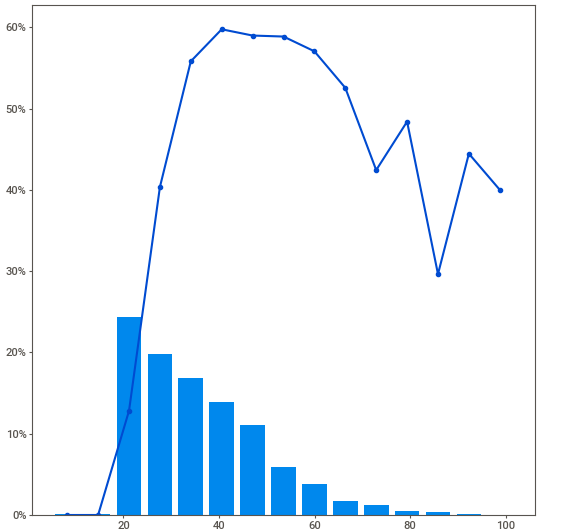
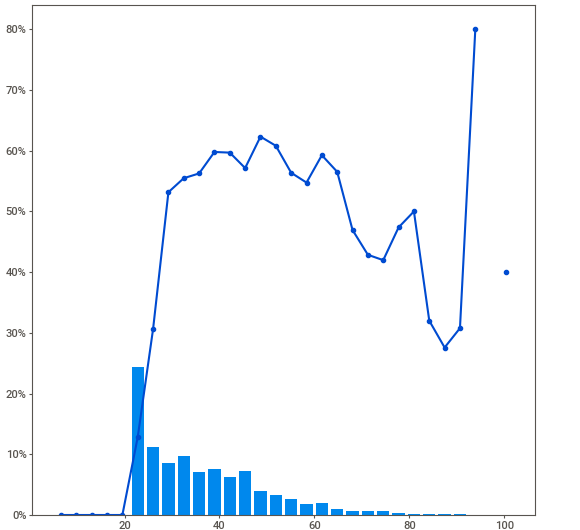
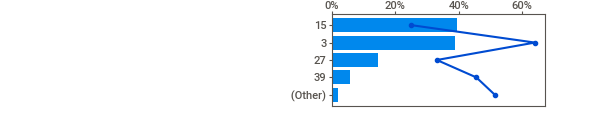
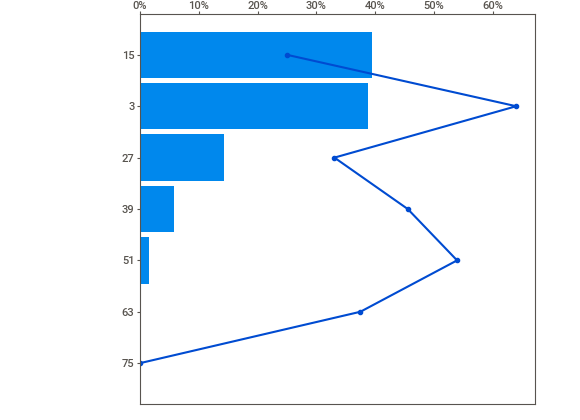
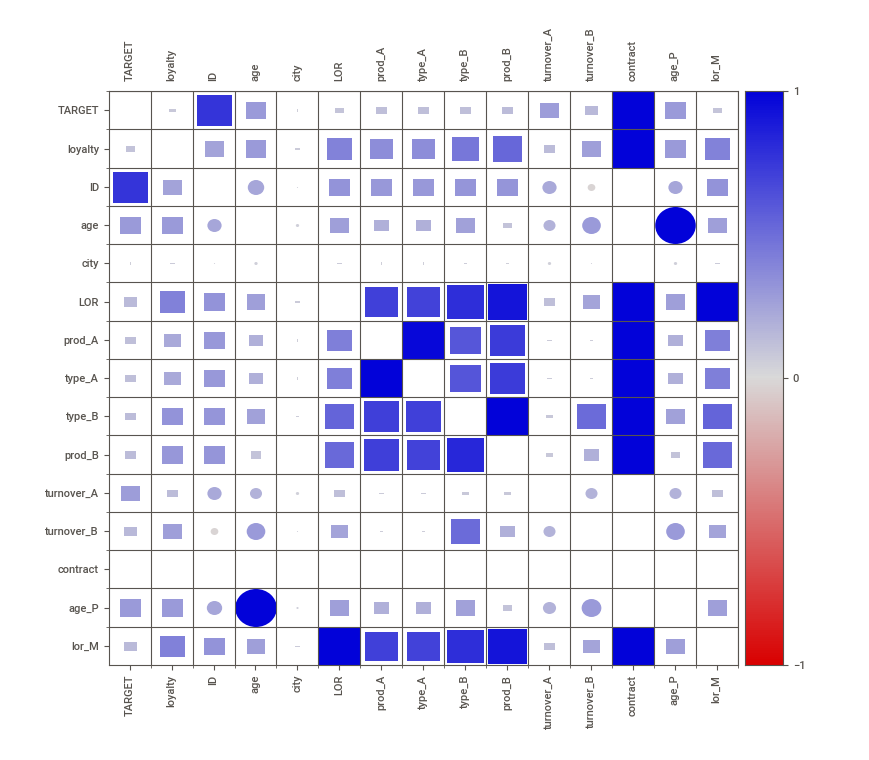
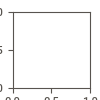

In [ ]:
my_report.show_notebook()

From the first file in the report, it looks like LOR, type_B, prod_B, type_A, prod_A, and loyalty are going to be the relevant features in our models.

# Data Preparation

LIST OF THINGS TO CHANGE

* create df_prep to preserve original data
* drop duplicate rows from ID 
* drop columns 
  * ID
  * contract
  * LOR
  * age_P
* Dummy Data
  * city change to indicator column not in city_2 
  * Modify loyalty to preserve cardinality and ordinality
* standardize and normalize
  * turnover_A
  * turnover_B
  * age
  * lor_M

note: we did not transform type_A or type_B, as we decide to remove these features during independence testing.

### Create df_prep

In [ ]:
df_prep = df.copy()

### Drop Duplicate Rows

In [ ]:
#sanity check part 1
df_prep.duplicated().sum()

3008

In [ ]:
df_prep = df_prep.drop_duplicates().copy()
df_prep.duplicated().sum()#sanity check part 2

0

### Drop Columns

In [ ]:
df_prep.drop(columns=["ID", "age_P", "contract", 'LOR'], inplace=True)

### Categorical Updates


#### city

In [ ]:
#create city 2 indicator
df_prep['city_2'] = (df_prep['city'] == 2).astype(int);

In [ ]:
#sanity check to see if city = 2 has created value =1 in city_2 dummy column
df_prep[['city','city_2']].head(2) 

,city,city_2
0,2,1
1,2,1


In [ ]:
#sanity check to see if city != 2 has created value = 0 in city_2 dummy column
df_prep[['city','city_2']].loc[df_prep['city'] != 2].head(2)

,city,city_2
56,5,0
236,4,0


In [ ]:
#drop city column
df_prep.drop(columns=['city'], inplace=True)

#### loyalty



In [ ]:
#double check loyalty values
df_prep['loyalty'].head()

0    99
1     1
2     1
3    99
4    99
Name: loyalty, dtype: int64

In [ ]:
#add 1 to every value, preparing to "shuffle" the 99 value to the newly emptied 0 value
df_prep['loyalty'] = df_prep['loyalty']+1 
df_prep['loyalty'].head()

0    100
1      2
2      2
3    100
4    100
Name: loyalty, dtype: int64

In [ ]:
#replace all 100 values with 0
df_prep['loyalty'].replace(100,0,inplace=True)
df_prep['loyalty'].head()

0    0
1    2
2    2
3    0
4    0
Name: loyalty, dtype: int64

In [ ]:
#add indicator column for uncategorized loyalty
df_prep['loyal_uncat'] =  (df_prep['loyalty'] == 0).astype(int)

### Normalize & Standardize

In [ ]:
#turnover_A, turnover_B, lor_M will be standardized and normalized
from sklearn.preprocessing import power_transform as pt 

columns = ['turnover_A', 'turnover_B','lor_M']

for column in columns:#iterate over identified columns
  a = df_prep[[column]]
  df_prep[column] = pt(a,method='box-cox')

df_prep[columns].head()#sanity check

,turnover_A,turnover_B,lor_M
0,-0.706074,0.687482,-1.284430
1,0.728694,1.039941,1.627726
2,-0.445272,2.436374,1.084097
3,1.514769,0.145817,-1.284430
4,0.546396,1.071100,-1.284430


In [ ]:
#age will be only normalized, otherwise it leads to underflow encountered in exp

df_prep['age'] = pt(a,method='box-cox',standardize=False)
df_prep['age'].head()#sanity check

0    1.268864
1    6.075943
2    5.178578
3    1.268864
4    1.268864
Name: age, dtype: float64

# Data Review
We will now review our data preparation, to check to see that we have improved our data set. We already know that we removed duplicate rows and columns. Now we will check to make sure we have removed all null values, check to see if the univariate analyses have improved, and review our multivariate analyses.

## Distribution Review

0    0.726744
1    0.273256
Name: TARGET, dtype: float64
Nullcount: 0.000000


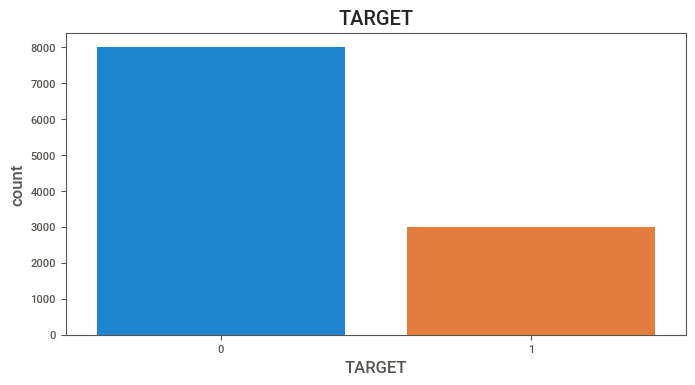

In [ ]:
distbox(0,df_prep,type='categorical')

After dropping values, this has become a highly imbalanced response variable. We will take this into account in our model selection.

In [ ]:
#first we will load our transformed dataset to review it as a whole, and then compare it to the original
df_prep.head()

,TARGET,loyalty,age,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,lor_M,city_2,loyal_uncat
0,1,0,1.268864,0,0,0,0,-0.706074,0.687482,-1.284430,1,1
1,1,2,6.075943,1,3,3,1,0.728694,1.039941,1.627726,1,0
2,1,2,5.178578,1,3,6,1,-0.445272,2.436374,1.084097,1,0
3,1,0,1.268864,0,0,0,0,1.514769,0.145817,-1.284430,1,1
4,1,0,1.268864,0,0,0,0,0.546396,1.071100,-1.284430,1,1


In [ ]:
df.shape

(14016, 15)

In [ ]:
df_prep.shape

(11008, 12)

We started with 15 features and reduced that number to 12, some of which are indicator variables. We also removed ~3000 duplicate values.

### Univariate Review

#### loyalty

0    0.458576
4    0.245367
2    0.183412
3    0.107558
1    0.005087
Name: loyalty, dtype: float64
Nullcount: 0.000000


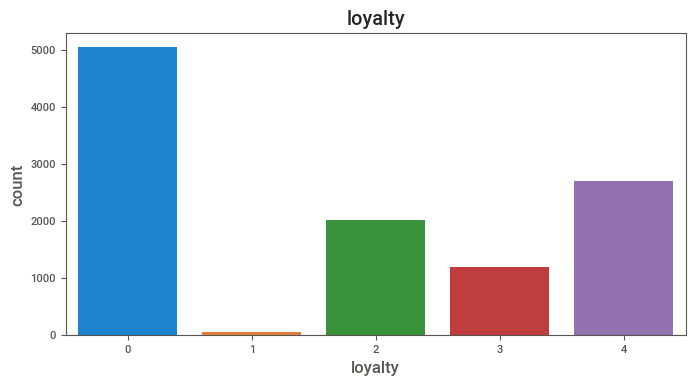

In [ ]:
distbox(1,df_prep,type = 'categorical')#????? why didnt we change

We are hoping this "rearranged" data improves our model. At the very least the "99" will no longer have an outsized impact on the model.

#### age

Skewness: -0.099043
Kurtosis: -1.132372
count    11008.000000
mean         3.389065
std          1.650769
min          1.268864
25%          1.268864
50%          3.908757
75%          3.908757
max          7.896385
Name: age, dtype: float64
Nullcount: 0.000000


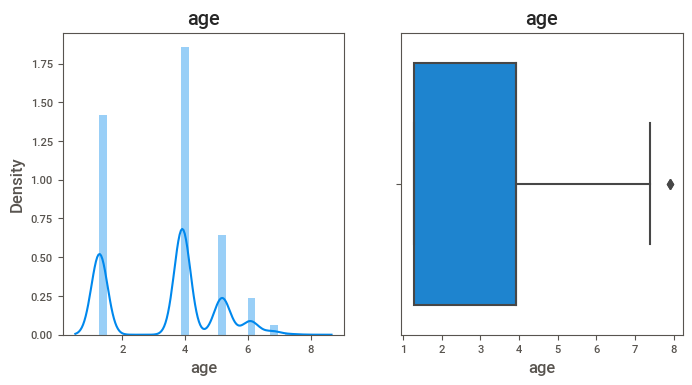

In [ ]:
distbox(2,df_prep)

We have decreased the skew and kurtosis, though it is less interpretable.

#### turnover_A

Skewness: 0.055569
Kurtosis: -0.484694
count    1.100800e+04
mean    -2.292991e-09
std      1.000045e+00
min     -1.997145e+00
25%     -7.485809e-01
50%      6.961195e-02
75%      6.736942e-01
max      3.262091e+00
Name: turnover_A, dtype: float64
Nullcount: 0.000000


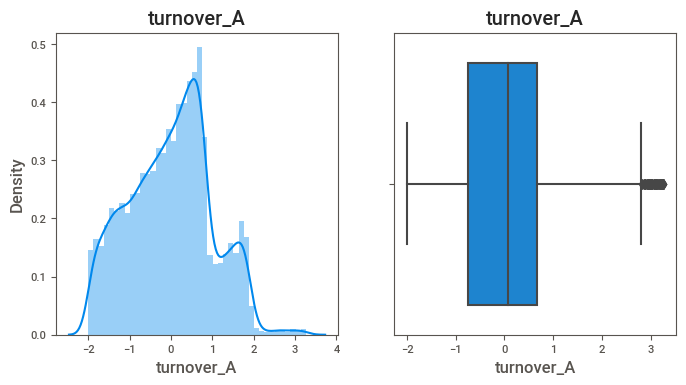

In [ ]:
distbox(7,df_prep)

Using metrics of skew and kurtosis, this feature is much improved.

#### turnover_B

Skewness: 0.733173
Kurtosis: 0.271479
count    1.100800e+04
mean    -1.124334e-09
std      1.000045e+00
min     -2.219340e+00
25%     -7.127797e-01
50%     -7.866306e-02
75%      4.461401e-01
max      2.455805e+00
Name: turnover_B, dtype: float64
Nullcount: 0.000000


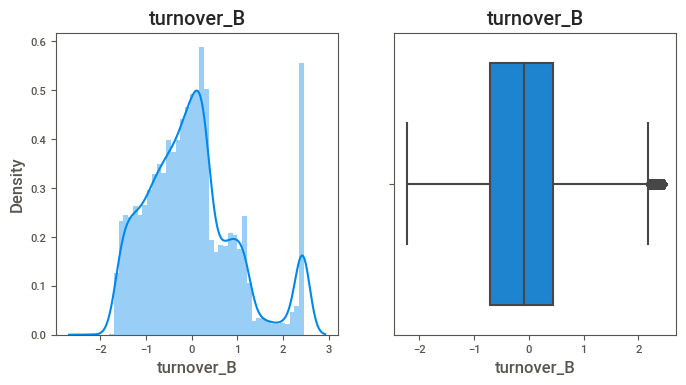

In [ ]:
distbox(8,df_prep)

Using metrics of skew and kurtosis, this feature is much improved.

#### lor_M



Skewness: -0.099043
Kurtosis: -1.132372
count    1.100800e+04
mean    -2.832440e-16
std      1.000045e+00
min     -1.284430e+00
25%     -1.284430e+00
50%      3.148325e-01
75%      3.148325e-01
max      2.730561e+00
Name: lor_M, dtype: float64
Nullcount: 0.000000


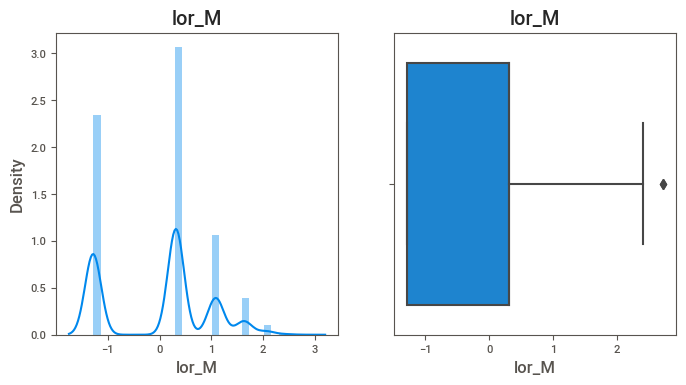

In [ ]:
distbox(9,df_prep)

We have reduced kurtosis and skew by normalizing and standardizing. We expect this to improve model performance, though if we have time we may attempt other transformations on this feature (or even use an untransformed feature) to see if the alternatives increase model performance.

#### city_2	

1    0.978289
0    0.021711
Name: city_2, dtype: float64
Nullcount: 0.000000


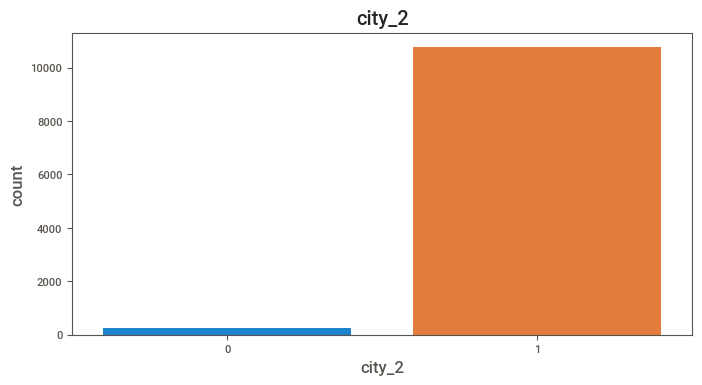

In [ ]:
distbox(10,df_prep,type= 'categorical')

Though the feature remains unbalanced, we expect the collapse of all other cities into a single value (an indicator column) to improve  model performance. We will leave this feature transformed for models which choose their own features, but because there is almost no variance we will not include it in models that we select features for.

### Multivariate Review

### Quantitative Independence

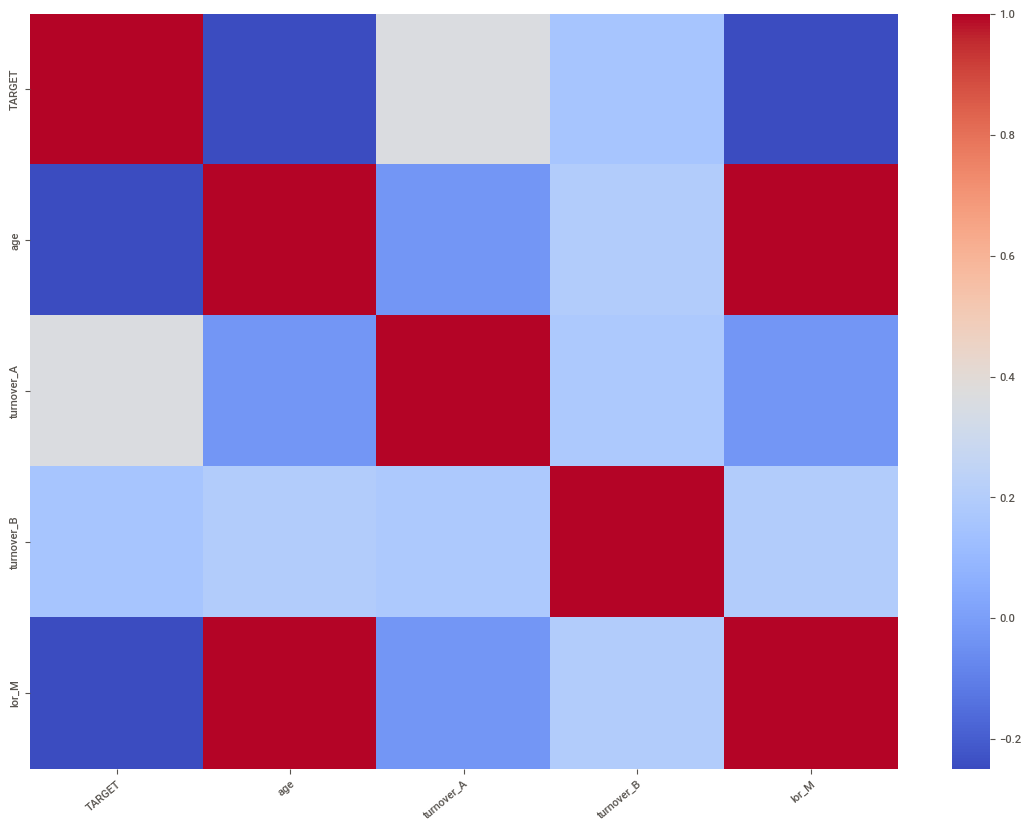

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(df_prep[['TARGET','age','turnover_A','turnover_B','lor_M']].corr(),cmap='coolwarm',annot=False);
plt.xticks(rotation=40 , rotation_mode='anchor',ha="right");

Our quantitative columns seem to be independent.

### Categorical Independence

For the categorical columns, we will use chi<sup>2</sup> test for independence and a spearman r to get the  exact correlation

We will get the scores for each column pair and create a heat map to visualize our results. 

code referenced from:
[Analytics_vidhya](https://www.analyticsvidhya.com/blog/2021/06/decoding-the-chi-square-test%E2%80%8A-%E2%80%8Ause-along-with-implementation-and-visualization/)



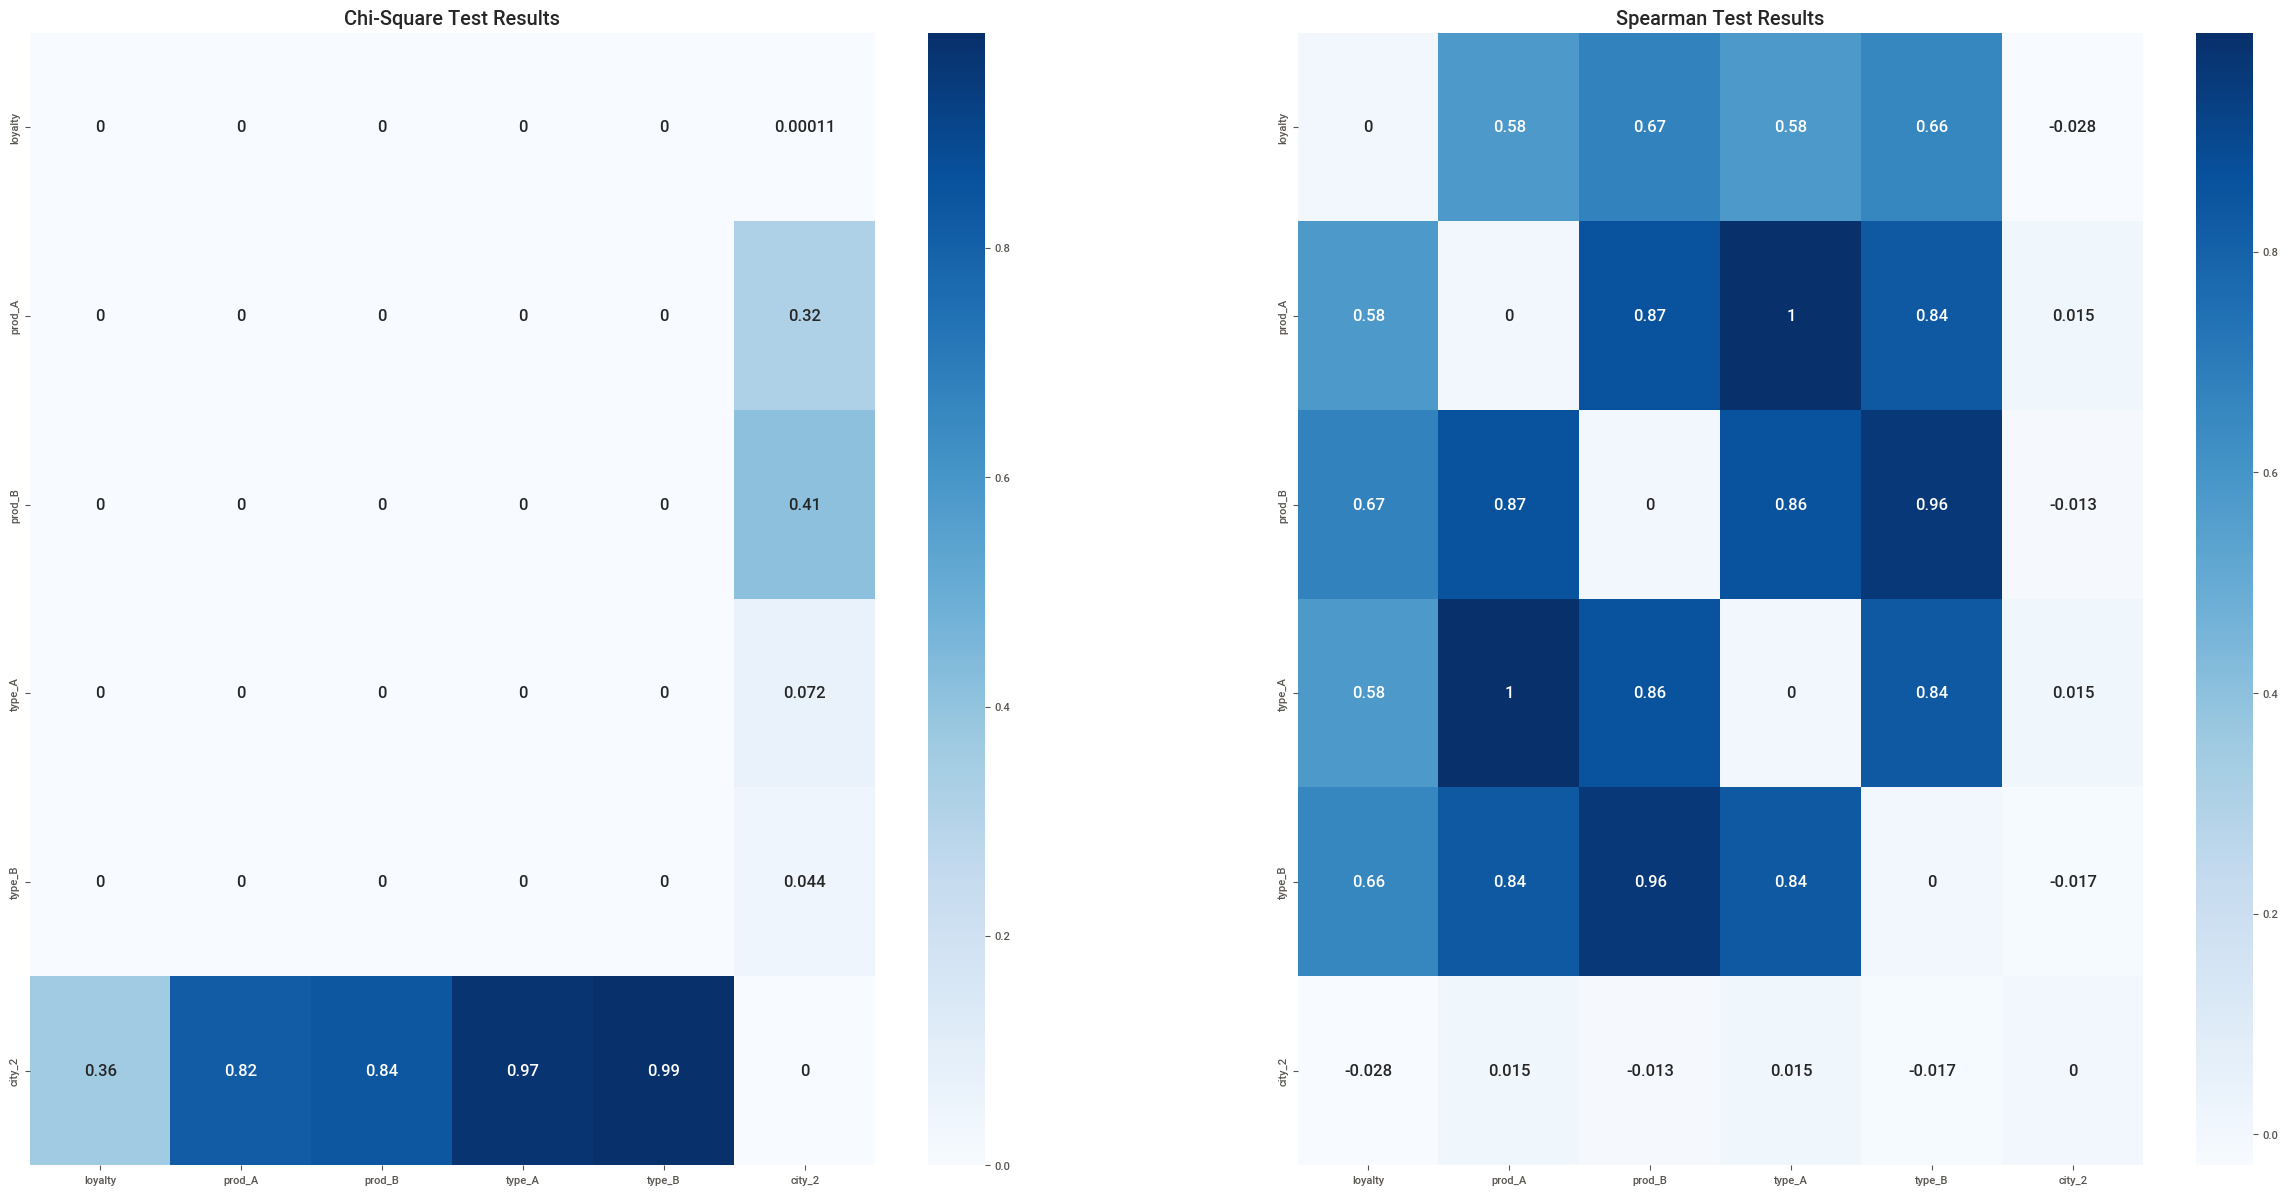

In [ ]:
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
cat_columns = ['loyalty', 'prod_A','prod_B', 'type_A', 'type_B', 'city_2']

chi_ps =[]
spearman = []
for cat in cat_columns:
  intermediate_P = []
  intermediat_spear = []
  for second_cat in cat_columns:
    if cat == second_cat:
      intermediate_P.append(0)
      intermediat_spear.append(0)
      continue
    chi = chi2(df_prep[cat].values.reshape(-1, 1),df_prep[second_cat].values.reshape(-1, 1))
    intermediate_P.append(chi[1][0])
    spear = spearmanr(df_prep[cat].values.reshape(-1, 1),df_prep[second_cat].values.reshape(-1, 1))
    intermediat_spear.append(spear[0])
  chi_ps.append(intermediate_P)
  spearman.append(intermediat_spear)


df_pvalues = pd.DataFrame(data= chi_ps,index=cat_columns,columns=cat_columns)
df_spearman = pd.DataFrame(data= spearman,index=cat_columns,columns=cat_columns)
#print(intermediat_spear)
#df_pvalues
fig = plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
sns.heatmap(df_pvalues, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.subplot(1,2,2)
sns.heatmap(df_spearman, annot=True, cmap='Blues')
plt.title('Spearman Test Results')
plt.show()


**conclusion**  
$\tilde{\chi}^2$ - our columns pairs mostly have a P-value of less than .05 from the test, except for city. We primarily accept the alternative hypothesis of the $\tilde{\chi}^2$ that these columns are not independent. 

Spearman r - confirms the results with two columns being 1 perfectly correlated. 

We will investigate our highest spearman r columns below to sanity check.

In [ ]:
#diving into a couple of examples
pd.crosstab(df['type_A'],df['prod_A'])

prod_A,0,1
type_A,,
0,6534,0
3,0,7452
6,0,30


In [ ]:
pd.crosstab(df['type_B'],df['prod_B'])

prod_B,0,1
type_B,,
0,5614,0
3,0,7874
6,0,493
9,0,35


This can see there isn't a lot of variance across these variables. They are not independent, which is not ideal for logistic regressions, though that is primarily for explainability. We will use only prod_A and prod_B, and not both in our initial feature selection to reduce dependent features.
##### drop non-independent columns

In [ ]:
df_extras = df_prep[['type_A','type_B']] # saving for recersive and fother feature selection techinques below
df_prep.drop(columns=['type_A','type_B'], inplace=True)
df_prep.head()#sanity check

,TARGET,loyalty,age,prod_A,prod_B,turnover_A,turnover_B,lor_M,city_2,loyal_uncat
0,1,0,1.268864,0,0,-0.706074,0.687482,-1.284430,1,1
1,1,2,6.075943,1,1,0.728694,1.039941,1.627726,1,0
2,1,2,5.178578,1,1,-0.445272,2.436374,1.084097,1,0
3,1,0,1.268864,0,0,1.514769,0.145817,-1.284430,1,1
4,1,0,1.268864,0,0,0.546396,1.071100,-1.284430,1,1


### TARGET Compared to Features

In [ ]:
my_report = sv.analyze(df_prep, target_feat =  'TARGET')

                                             |          | [  0%]   00:00 -> (? left)


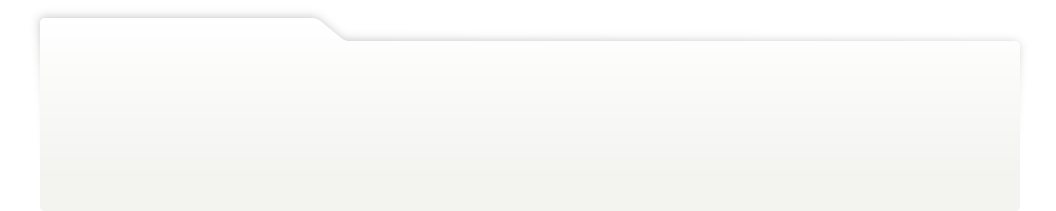
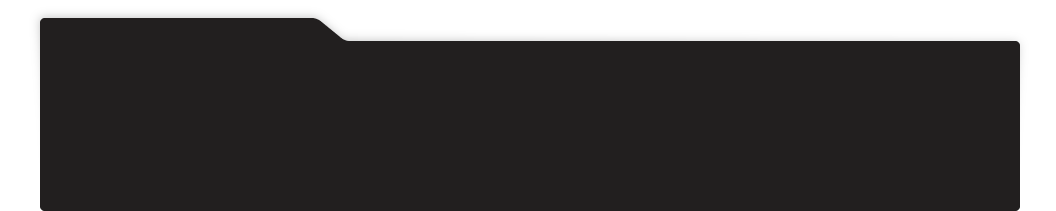
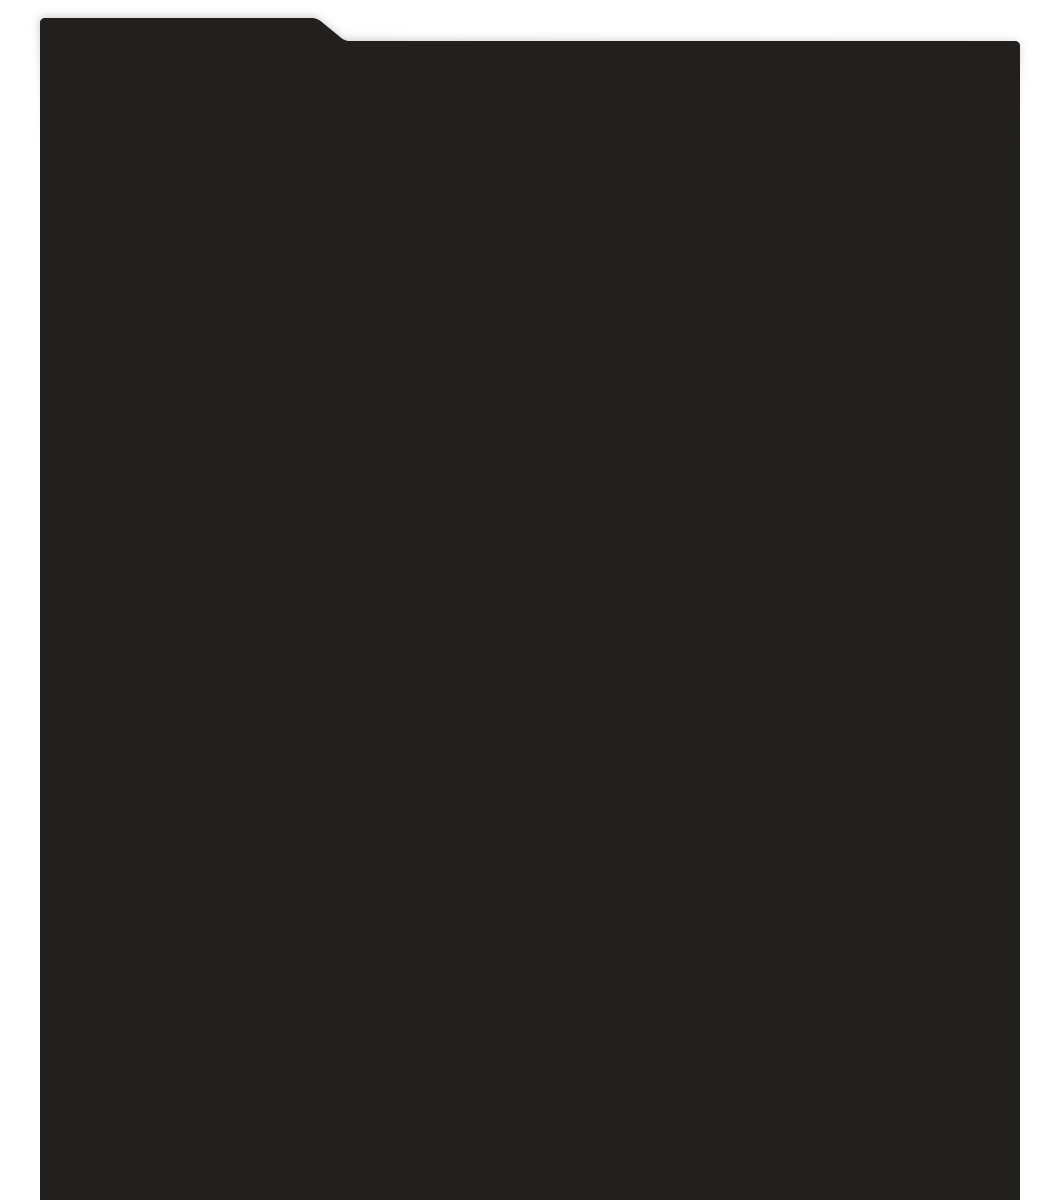
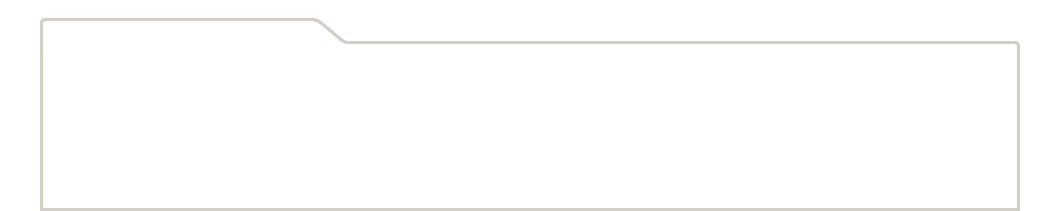
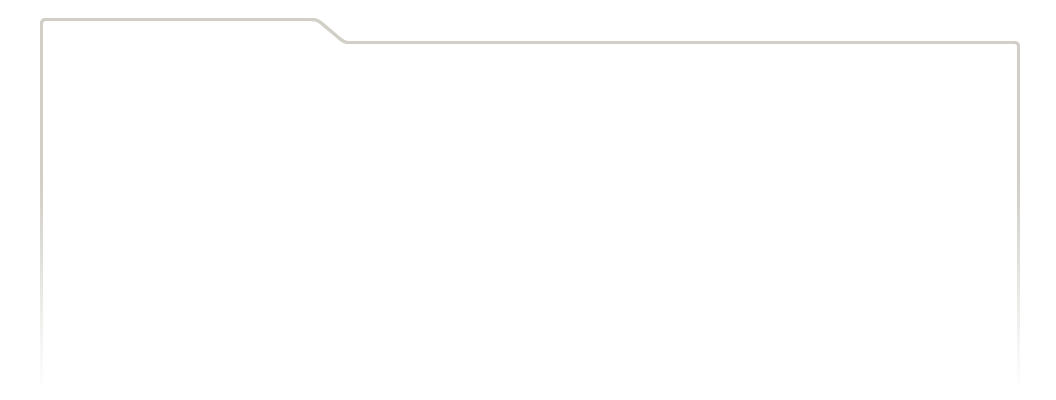
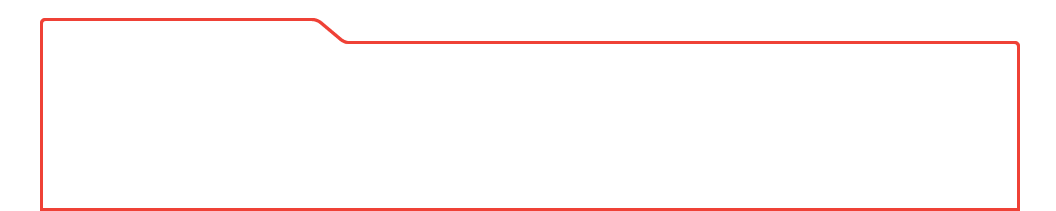
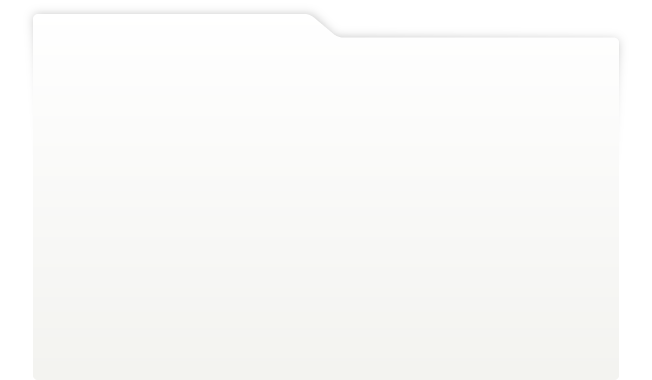
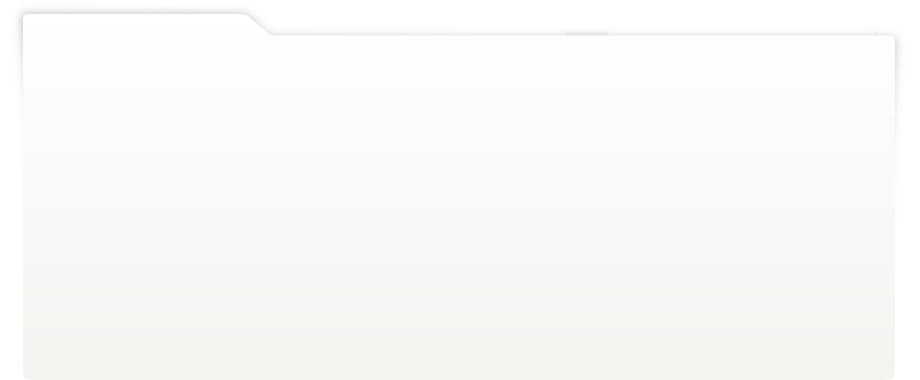
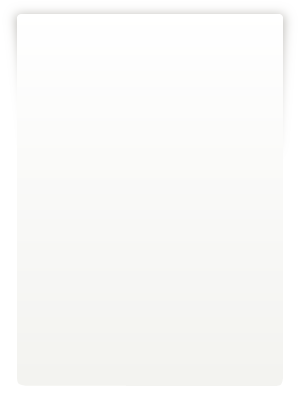
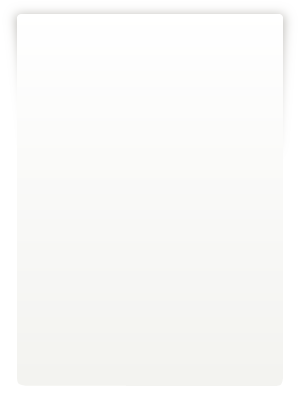
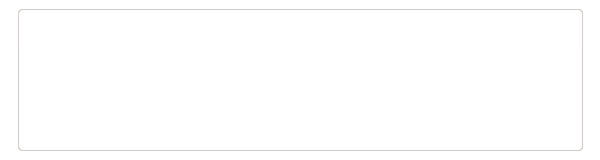
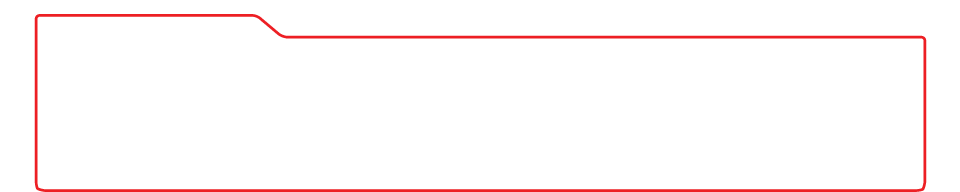
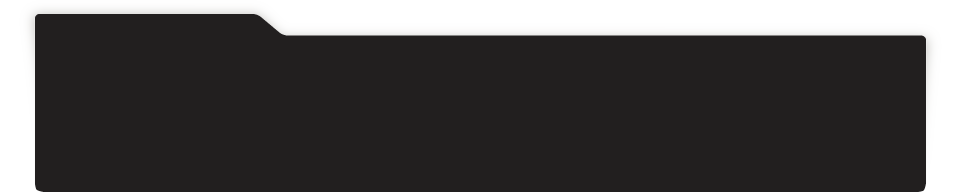
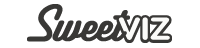
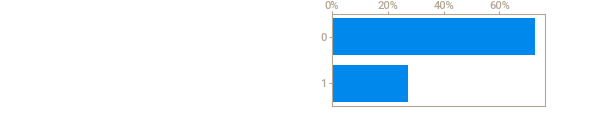
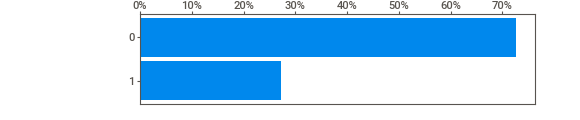
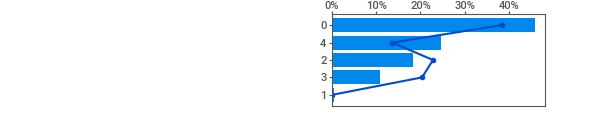
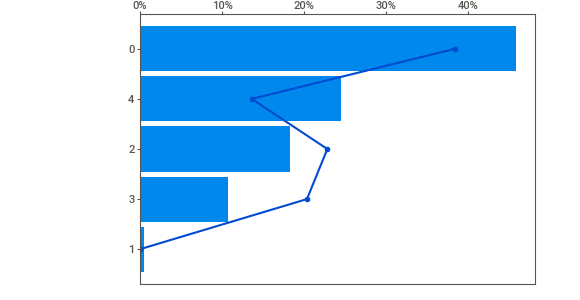
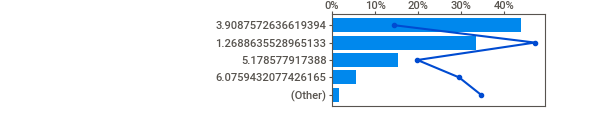
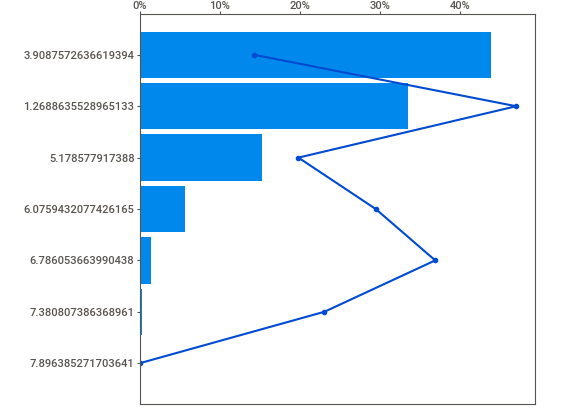
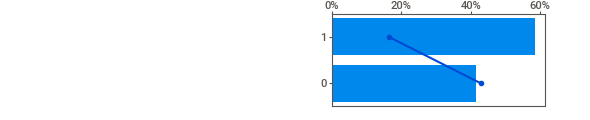
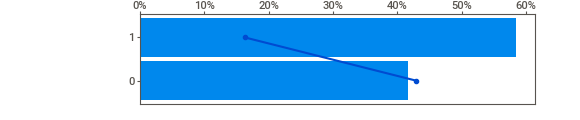
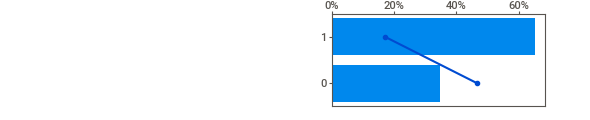
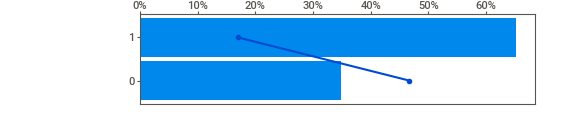
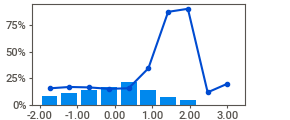
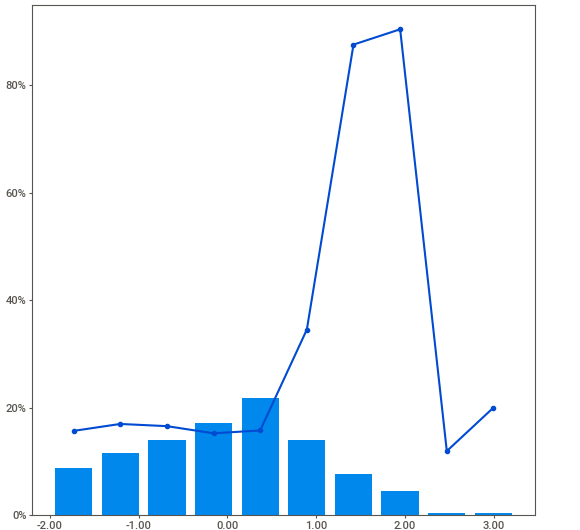
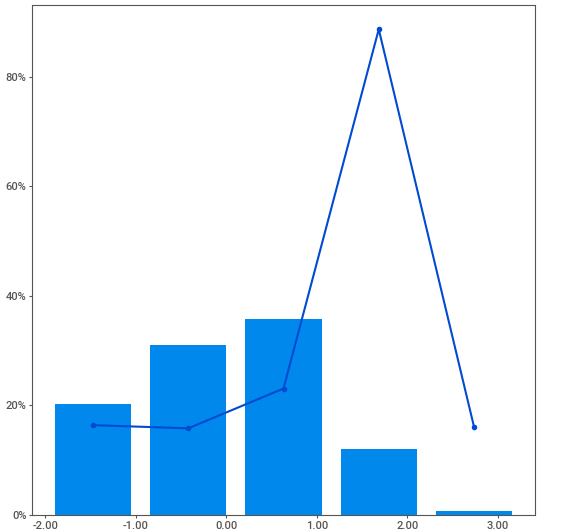
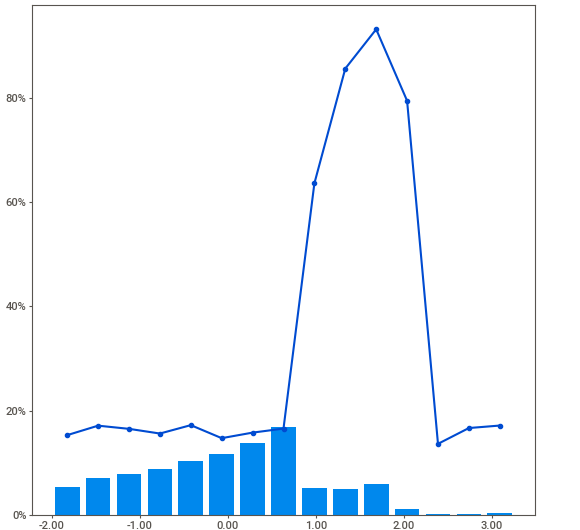
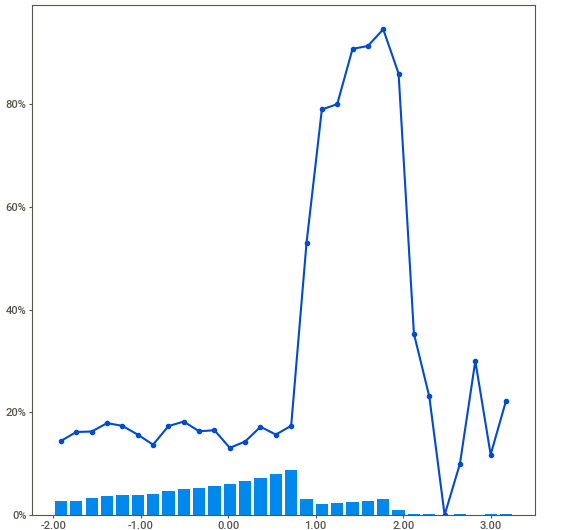
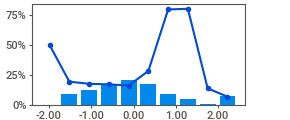
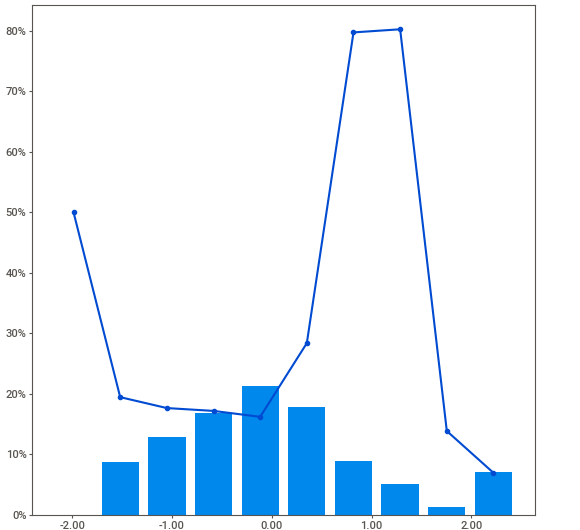
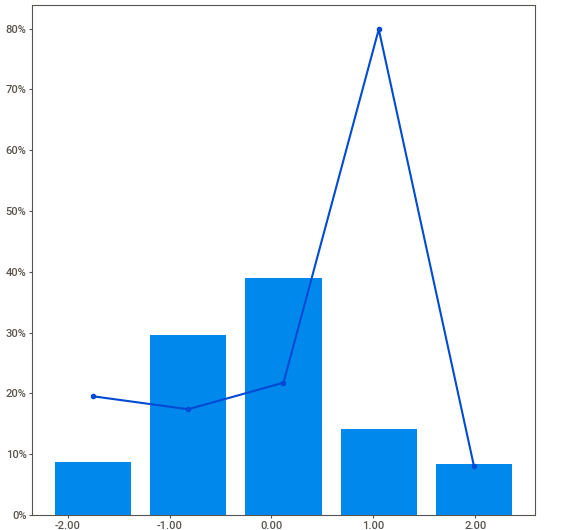
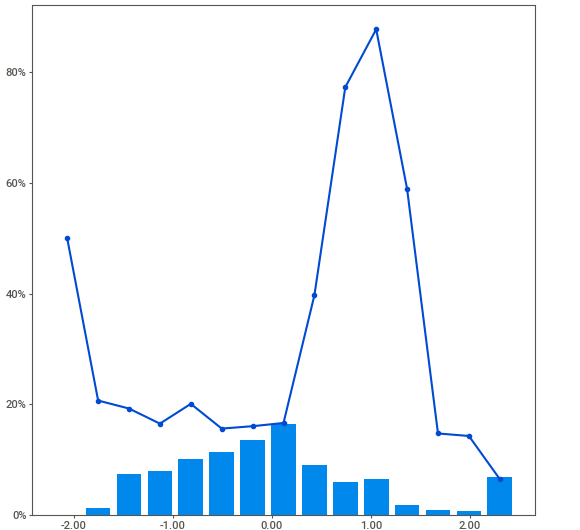
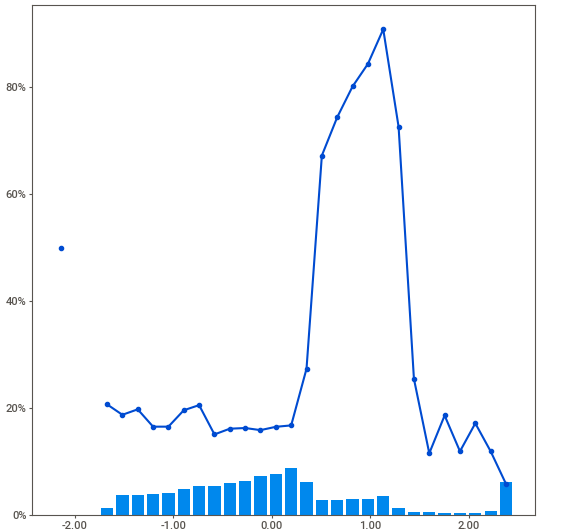
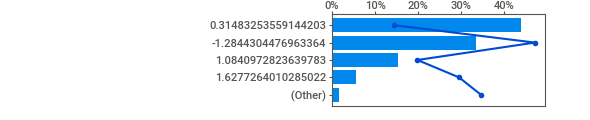
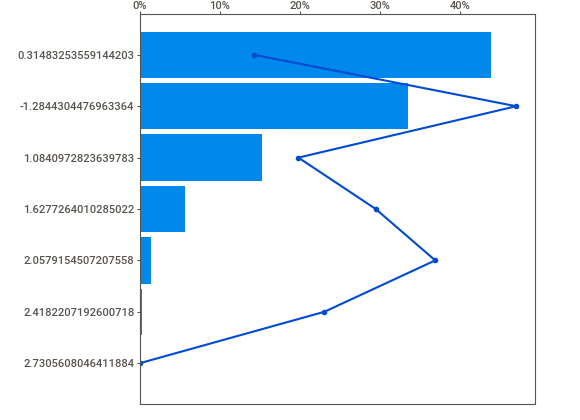
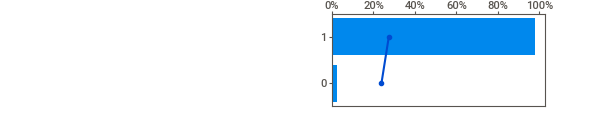
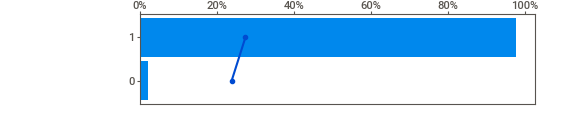
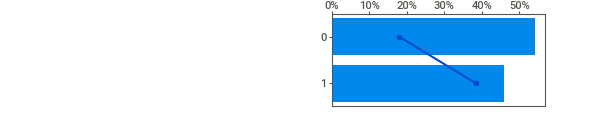
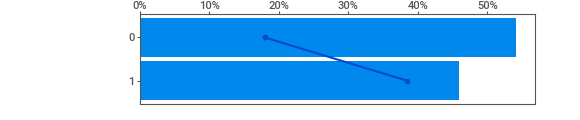
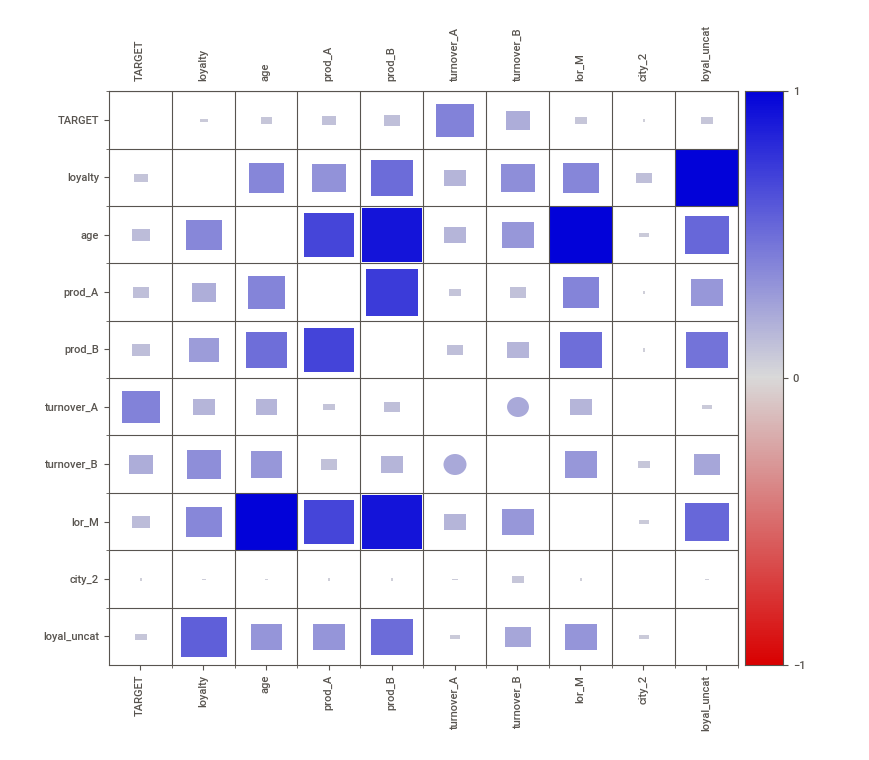
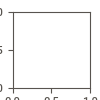

In [ ]:
my_report.show_notebook()

# Regression Modeling 

-------

## Feature Selection

### Feature Selection 1

Our first model will use the features we have prepared and selected so far in our df_prep dataframe. We will choose features that contribute at least .05 information on the TARGET ie age, lor_M, prod_B, prod_A, loyalty

In [ ]:
#creating a new dataframe for selected features
features_1 = df_prep[['TARGET','age','lor_M','prod_A','prod_B','loyalty']]

#### Split Train Test

In [ ]:
# Separate features and response variables. 
# sparse_columns = ['loyalty']

X1 = features_1.drop(['TARGET'], axis = 1).values# assign the explanatory variables to a Python object
y1 = df_prep.TARGET.values# assign the response variable to a Python object

# split the data into training + testing subsets. code removed when implementing a test/train/validate split
#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify = y1 #stratifying to account for sparse classes)

#split training, testing, validating subsets based on code found here: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
X1_remaining, X1_test, y1_remaining, y1_test = train_test_split(
    X1, y1, 
    test_size=ratio_test, 
    random_state=42,
    stratify = y1 #stratifying to account for sparse classes
    )

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X1_train, X1_val, y1_train, y1_val = train_test_split(
    X1_remaining, y1_remaining, 
    test_size=ratio_val_adjusted,
    random_state=42,
    stratify = y1_remaining
    )

### Feature Selection 2

For our second feature set, we will use backward selection using a linear estimator along with some automated transformations from the original set, to see if our manual work was worthwhile.

steps:
  * replace city with city_2 from data_prep
  * dummy 
    * type_A
    * type_B
  * standardize
    * age
    * turnover_A
    * turnover_B
    * LOR_M <- this we will not center as having a negative relationship length isn't interpretable.




In [ ]:
#selecting features creating dummies
formula = """  TARGET ~ loyalty + standardize(age) + LOR + prod_A + prod_B + C(type_A,Treatment(0)) + C(type_B,Treatment(0)) + standardize(turnover_A) + standardize(turnover_B) +  standardize(lor_M ,center=False) """

# replacing city_2 with city 
data = df.copy()
data = data.drop_duplicates().copy()
data['city'] = df_prep.city_2
y2, X2 = dmatrices(formula, data=data, return_type='dataframe')

# we will drop the intercept because we forced our 0 values from type_A and Type_B into is and because we know those values are redundant to prod_A prod_B
X2.drop(columns='Intercept', inplace=True)
y2 = np.ravel(y2.values)
X2.head()

,"C(type_A, Treatment(0))[T.3]","C(type_A, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.3]","C(type_B, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.9]",loyalty,standardize(age),LOR,prod_A,prod_B,standardize(turnover_A),standardize(turnover_B),"standardize(lor_M, center=False)"
0,0.0,0.0,0.0,0.0,0.0,99.0,2.390603,0.0,0.0,0.0,-0.401021,-0.151425,0.266135
1,1.0,0.0,1.0,0.0,0.0,1.0,0.779209,3.0,1.0,1.0,0.231723,-0.112932,3.459757
2,1.0,0.0,0.0,1.0,0.0,1.0,0.549010,2.0,1.0,1.0,-0.311863,1.585718,2.395216
3,0.0,0.0,0.0,0.0,0.0,99.0,-0.295054,0.0,0.0,0.0,0.842203,-0.194105,0.266135
4,0.0,0.0,0.0,0.0,0.0,99.0,2.083671,0.0,0.0,0.0,0.126654,-0.108920,0.266135


#### Split Test Train

In [ ]:
#split train/test commented out in favor of split train/test/validate
#X2_train, X2_test, y2_train, y2_test= train_test_split(X2, y2,test_size=0.2, random_state=42,stratify = y2 #stratifying to account for sparse classes)
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
X2_remaining, X2_test, y2_remaining, y2_test = train_test_split(
    X2, y2, 
    test_size=ratio_test, 
    random_state=42,
    stratify = y2 #stratifying to account for sparse classes
    )

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2_remaining, y2_remaining, 
    test_size=ratio_val_adjusted,
    random_state=42,
    stratify = y2_remaining
    )                                                       

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define the method
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=4)
# fit the model
rfe.fit_transform(X2_train, y2_train)
# transform the data
#X, y = rfe.transform(X, y)

array([[ 0.7792088 ,  0.        ,  0.22203494, -0.20729651],
       [ 0.01187801,  0.        ,  0.72160619, -0.25761677],
       [ 0.16534417,  0.        ,  0.47713897, -0.2596138 ],
       ...,
       [-0.52525354,  1.        ,  0.15630552, -0.19061415],
       [ 0.16534417,  1.        , -0.52995346,  1.17018313],
       [ 1.00940803,  1.        , -0.53271462, -0.23531189]])

In [ ]:
rfe.get_support()

array([False, False, False, False, False, False,  True, False, False,
        True,  True,  True, False])

In [ ]:
selected_feat= X2_train.columns[(rfe.get_support())]
len(selected_feat)

4

In [ ]:
print(selected_feat)

Index(['standardize(age)', 'prod_B', 'standardize(turnover_A)',
       'standardize(turnover_B)'],
      dtype='object')


## Model Building

We will use the training subset to construct two different KNN models and two different SVM models using different combinations of explanatory variables.

### Null Error Rate
This is a measure of how wrong the classifier would be if it predicted just the majority class. The formula is (Actual:Number/Total Sample). 

In [ ]:
(len(X1_train)-y1_train.sum())/len(X1_train)#total count minus positive count divided by total count

0.7267771973654327

### KNN

##### Feature Set 1

In [ ]:
# based on https://realpython.com/knn-python/
from sklearn.neighbors import KNeighborsClassifier
knn_model1 = KNeighborsClassifier(n_neighbors=11,#11 neighbors maximizes the score. Changing the algorithm or distance metric fails to modify our score.
                                 p=2)#p=2 improves the model slightly
knn_model1.fit(X1_train, y1_train)


KNeighborsClassifier(n_neighbors=11)

###### Evaluate Model

In [ ]:
knn_model1.score(X1_test, y1_test)

0.7284287011807448

This Accuracy scores worse than our null error rate.

In [ ]:
knn_model1.predict(X1[[0]])

array([0])

In [ ]:
knn_model1.predict_proba(X1[[0]])

array([[0.54545455, 0.45454545]])

In [ ]:
#evaluation code taken from https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
y1_pred = knn_model1.predict(X1_test)
print(confusion_matrix(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

[[791   9]
 [290  11]]
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       800
           1       0.55      0.04      0.07       301

    accuracy                           0.73      1101
   macro avg       0.64      0.51      0.45      1101
weighted avg       0.68      0.73      0.63      1101



##### Feature Set 2


In [ ]:
knn_model2 = KNeighborsClassifier(n_neighbors=5#5 neighbors maximizes the accuracy score. Changing the algorithm or distance metric fails to modify our score.
                                 )
knn_model2.fit(X2_train[selected_feat], y2_train)


KNeighborsClassifier()

###### Evaluate Model

In [ ]:
knn_model2.score(X2_test[selected_feat], y2_test)

0.8483197093551317

In [ ]:
y2_pred = knn_model2.predict(X2_test[selected_feat])
print(confusion_matrix(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

[[757  43]
 [124 177]]
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       800
         1.0       0.80      0.59      0.68       301

    accuracy                           0.85      1101
   macro avg       0.83      0.77      0.79      1101
weighted avg       0.84      0.85      0.84      1101



### SVM

#### Feature Set 1

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(random_state=42, 
           probability=True,
           C=1,
           kernel= 'sigmoid' #sigmoid kernal trick is only one that is able to prperly classify data
           )
svc1.fit(X1_train, y1_train)

SVC(C=1, kernel='sigmoid', probability=True, random_state=42)

##### Evaluate Model

In [ ]:
#accuracy
svc1.score(X1_test, y1_test)

0.6948228882833788

In [ ]:
y1_pred = svc1.predict(X1_test)
print(confusion_matrix(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

[[757  43]
 [293   8]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       800
           1       0.16      0.03      0.05       301

    accuracy                           0.69      1101
   macro avg       0.44      0.49      0.43      1101
weighted avg       0.57      0.69      0.61      1101



#### Feature Set 2


In [ ]:
svc2 = SVC(random_state=42, 
           probability=True,
           C=50,
           kernel= 'rbf')#the poly kernel increases the f1 score by 1%, but takes a 10% hit to accuracy
svc2.fit(X2_train[selected_feat], y2_train)

SVC(C=50, probability=True, random_state=42)

##### Evaluate Model

In [ ]:
#accuracy
svc2.score(X2_test[selected_feat], y2_test)

0.8673932788374206

In [ ]:
y2_pred = svc2.predict(X2_test[selected_feat])
print(confusion_matrix(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

[[785  15]
 [131 170]]
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91       800
         1.0       0.92      0.56      0.70       301

    accuracy                           0.87      1101
   macro avg       0.89      0.77      0.81      1101
weighted avg       0.87      0.87      0.86      1101



## Model Comparison

###  Model Summary

| Model  | F1  | Accuracy |
|:-:|:-:|:--:|
| Null Error Rate |   | .727|
| KNN Model 1  | .07  | .728 |   
| KNN Model 2  | .68  | .848 |  
| SVM Model 1  | .05  | .695 | 
| SVM Model 2  | .70  | .867 |

### Model Selection

The null error rate for our dataset is .727. SVM Model 1 doesn't even beat that metric, which is sad. Its f1 score is also laughably small. That is our least effective model. 

Our highest f1 score is SVM2. We care about the f1 score more than accuracy because it _is_ an imbalanced response variable, but SMV2 also has our highest accuracy score.

We will now apply your preferred model to the validation subset and assess how well it performs on that previously unseen data.

### Model Validation

In [ ]:
#accuracy
svc2.score(X2_val[selected_feat], y2_val)

0.8710263396911898

In [ ]:
y2_val_pred = svc2.predict(X2_val[selected_feat])
print(confusion_matrix(y2_val, y2_val_pred))
print(classification_report(y2_val, y2_val_pred))

[[790  10]
 [132 169]]
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       800
         1.0       0.94      0.56      0.70       301

    accuracy                           0.87      1101
   macro avg       0.90      0.77      0.81      1101
weighted avg       0.88      0.87      0.86      1101



# Conclusion

Our model explorations showed us that SVM is not exclusively better than KNN (it proved worse in the manually transformed/selected features). Though in our case Support Vector Machines with backward selection (measured by a linear estimator) along with some automated transformations from the original set performed better than our manual transformations and selection. 

Using  Our EDA was still worthwhile to catch the duplicate rows and features though.

After tweaking the parameters of our models to optimize the scores we validated our choice with the previously unseen dataset, which gave us our highest accuracy score yet along with a tie for the greatest f1 score.